In [219]:
import pandas as pd
import pandas_profiling

import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image

from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


import time
from sklearn.manifold import TSNE

import seaborn as sn
sn.set(rc={'figure.figsize':(11.7,8.27)})
palette = sn.color_palette("bright", 10)

"""
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn.cluster import KMeans, SpectralClustering

import pydot
from IPython.display import Image

import time
from sklearn.manifold import TSNE
import seaborn as sb
sb.set(rc={'figure.figsize':(11.7,8.27)})
palette = sb.color_palette("bright", 10)
"""

# In order to see full screen (horizontal scrolling) dataframes
from IPython.display import display
pd.options.display.max_columns = None

# === === === === === === === === === ===
# Ziel / Problembeschreibung

Für den gewählten Datensatz soll versucht werden mittels Regressionsmethoden die Gehälter der NBA-Spieler vorherzusagen. Welche Features sind ausschlaggebend für ein hohes bzw. niedriges Gehalt?

Es soll ein Regressionsproblem gelöst werden, wodurch folgende Bereiche behandelt werden sollen:

- Linear Regression (Regression)
- KNN (Regression)
- Decision Tree (Regression)
- Neuronal Network (Regression)


- PCA (visualisieren)
- T-SNE (visualisieren)


- KMeans (CLustern)
- Spectral Clustering (Clustern)

TODO: Wie?

Dimensionality Reduction kannst du zum Visualisieren benutzen um visuell zu sehen, ob es Gruppierungen bei den Spielern gibt (Welche Features sind dabei wichtig? zb College oder Position).

Mit Clustering kannst du dann die Spieler in k Gruppen einteilen, abhängig von den sportlichen Werten (Wenn man ähnlich gute sportliche Werte hat, hat man dann auch ein ähnliches gutes Gehalt?

# === === === === === === === === === ===
# Daten

Die Datensätze __salaries__ und __players__ wurden aus folgender Quelle gewählt: https://data.world/datadavis/nba-salaries.

Der Datensatz __seasons_stats__ wurde aus folgender Quelle gewählt: https://www.kaggle.com/drgilermo/nba-players-stats

In [220]:
salaries_df = pd.read_csv('data/salaries.csv')
players_df = pd.read_csv('data/players.csv')
seasons_stats_df = pd.read_csv('data/seasons_stats.csv')

# === === === === === === === === === ===
# Datenaufbereitung

## === === === === === === === === === ===
## Dataframe: Salaries

Diese Daten von https://data.world/datadavis/nba-salaries bilden den Ausgangspunkt für die beschriebene Fragestellung. Der Datensatz beinhaltet im Wesentlichen das ausbezahlte __Gehalt__ an einen Spieler für eine bestimmte __Saison__.

In [221]:
salaries_df.sample()

,league,player_id,salary,season,season_end,season_start,team
12157,NBA,sundvjo01,176000,1985-86,1986,1985,San Antonio Spurs


### Pandas Profiling Report

Der nachfolgende _Pandas Profiling Report_ verschafft einen vollständigen Überblick (Statistiken, Visualisierungen) über den importierten Datensatz.

In [222]:
# salaries_profile_report = salaries_df.profile_report()
# salaries_profile_report.to_file(output_file="salaries_profile_report.html")

### Analyse der einzelnen Spalten

In [223]:
salaries_df.columns

Index(['league', 'player_id', 'salary', 'season', 'season_end', 'season_start',
       'team'],
      dtype='object')

#### League

Laut dem _Pandas Profiling Report_ handelt es sich bei der Variable __league__ um eine Konstante. Alle Spieler des Datensatzes sind in der _NBA_ tätig. Das Feature schafft somit keinen Mehrwert und kann entfernt werden.

In [224]:
salaries_df['league'].describe()

count     14163
unique        1
top         NBA
freq      14163
Name: league, dtype: object

In [225]:
salaries_df.drop(columns=['league'], inplace=True)

#### Player ID

Die Variable __player_id__ kann zunächst im Datensatz gelassen werden. Über diese ID können später die zusätzlichen Daten des Spielers vom Datensatz __Players__ eingebunden werden.

#### Salary

Die wichtigste Variable __salary__ wird natürlich im Datensatz behalten.

#### Season (Start, End)

Die Variablen __season__, __season_start__ und __season_end__ müssen nicht alle im Datensatz belassen werden. Die Variable __season__ kann aus den beiden anderen konstruiert werden und ist somit redundant. Sie kann somit entfernt werden.

In [226]:
salaries_df.drop(columns=['season'], inplace=True)

### Ergebnis

In [227]:
salaries_df.head()

,player_id,salary,season_end,season_start,team
0,abdelal01,395000,1991,1990,Portland Trail Blazers
1,abdelal01,494000,1992,1991,Portland Trail Blazers
2,abdelal01,500000,1993,1992,Boston Celtics
3,abdelal01,805000,1994,1993,Boston Celtics
4,abdelal01,650000,1995,1994,Sacramento Kings


In [228]:
salaries_df.tail()

,player_id,salary,season_end,season_start,team
14158,zipsepa01,750000,2017,2016,Chicago Bulls
14159,zipsepa01,1312611,2018,2017,Chicago Bulls
14160,zizican01,1645200,2018,2017,Cleveland Cavaliers
14161,zubaciv01,1034956,2017,2016,Los Angeles Lakers
14162,zubaciv01,1312611,2018,2017,Los Angeles Lakers


In [229]:
salaries_df.sample(7)

,player_id,salary,season_end,season_start,team
6769,jonesed02,2000000,2009,2008,Indiana Pacers
8053,martike01,1399507,2014,2013,New York Knicks
6993,keysra01,363000,1996,1995,Milwaukee Bucks
14127,youngth01,2901241,2011,2010,Philadelphia 76ers
8433,mckieaa01,2500000,2006,2005,Los Angeles Lakers
10199,polynol01,1000000,1999,1998,Seattle SuperSonics
3829,elsonfr01,620046,2005,2004,Denver Nuggets


In [230]:
salaries_df.describe()

,salary,season_end,season_start
count,1.416300e+04,14163.00000,14163.00000
mean,3.164870e+06,2003.66942,2002.66942
std,4.185046e+06,9.16469,9.16469
min,2.706000e+03,1985.00000,1984.00000
25%,6.300000e+05,1996.00000,1995.00000
50%,1.500000e+06,2004.00000,2003.00000
75%,3.884239e+06,2012.00000,2011.00000
max,3.468255e+07,2018.00000,2017.00000


In [231]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14163 entries, 0 to 14162
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   player_id     14163 non-null  object
 1   salary        14163 non-null  int64 
 2   season_end    14163 non-null  int64 
 3   season_start  14163 non-null  int64 
 4   team          14159 non-null  object
dtypes: int64(3), object(2)
memory usage: 553.4+ KB


## === === === === === === === === === ===
## Dataframe: Players

Die Daten von https://data.world/datadavis/nba-salaries komplementieren den zuvor beschriebenen __Salaries__ Datensatz. Sie beinhalten im Wesentlichen __Informationen zu den jeweiligen Spielern__.

In [232]:
players_df.sample()

,_id,birthDate,birthPlace,career_AST,career_FG%,career_FG3%,career_FT%,career_G,career_PER,career_PTS,career_TRB,career_WS,career_eFG%,college,draft_pick,draft_round,draft_team,draft_year,height,highSchool,name,position,shoots,weight
2320,komenmi01,"June 22, 1920",NaN,1.9,28.3,NaN,58.4,64,-,9.9,-,1.4,NaN,University of Wyoming,NaN,NaN,NaN,NaN,6-7,"Lew Wallace in Gary, Indiana",Milo Komenich,Forward/Center,Right,212lb


### Pandas Profiling Report

Der nachfolgende _Pandas Profiling Report_ verschafft einen vollständigen Überblick (Statistiken, Visualisierungen) über den importierten Datensatz.

In [233]:
# players_profile_report = players_df.profile_report()
# players_profile_report.to_file(output_file="players_profile_report.html")

### Analyse der einzelnen Spalten

In [234]:
players_df.columns

Index(['_id', 'birthDate', 'birthPlace', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_TRB', 'career_WS', 'career_eFG%', 'college', 'draft_pick',
       'draft_round', 'draft_team', 'draft_year', 'height', 'highSchool',
       'name', 'position', 'shoots', 'weight'],
      dtype='object')

#### ID

Die Variable __id__ kann zunächst im Datensatz belassen werden. Mit dieser Variable kann nämlich später das Matching mit dem __Salaries__ Datensatz vollzogen werden.

#### Birth Date

Laut dem _Pandas Profiling Report_ weißt die Variable __birthDate__ folgende Probleme auf:

- Hohe Kardinalität
- Uniform

Außerdem hat die Variable __28__ fehlende Datenpunkte.

Prinzipiell könnten die Features _birth_month_, _birth_day_ und _birth_year_ aus der genannten Variable entnommen werden. Dies scheint auf den ersten Blick jedoch keinen wirklichen Mehrwert zu bieten. Somit wird dieses Feature verworfen.

In [235]:
players_df.drop(columns=['birthDate'], inplace=True)

#### Birth Place

Laut dem _Pandas Profiling Report_ weißt die Variable __birthPlace__ folgende Probleme auf:

- Fehlende Datenpunkte || 10.7%
- Hohe Kardinalität || 39%


##### Fehlende Datenpunkte

Die fehlenden Daten werden mit dem Top-Wert aufgefüllt.

In [236]:
players_df['birthPlace'].describe()

count                  4185
unique                 1632
top       Chicago, Illinois
freq                    137
Name: birthPlace, dtype: object

In [237]:
players_df['birthPlace'] = players_df['birthPlace'].fillna("Chicago, Illinois")

##### Hohe Kardinalität

Um dieses Problem zu lösen soll nur das Land in Betracht gezogen werden. Eine drastischere Maßnahme wäre die reine Verwendung des Features __born_in_usa__. Diese Variable wurde nur Aufschluss darüber geben, ob der Spieler in der USA geboren wurde oder nicht.

In [238]:
players_df['birthPlace'].describe()

count                  4685
unique                 1632
top       Chicago, Illinois
freq                    637
Name: birthPlace, dtype: object

Wie man oberhalb erkennen kann weißt das Feature 1632 einmalige Werte auf.

In [239]:
def generalizeBirthPlace(birthPlace):
    splitted =  birthPlace.split(",")
    
    return splitted[1] if len(splitted) >= 2 else ",".join(splitted)

In [240]:
def statesToUSA(birthPlace):
    states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
              "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
              "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
              "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]
    
    def process(string):
        return string.lower().strip()
        
    states = map(process, states)
    
    return "USA" if process(birthPlace) in states else birthPlace

In [241]:
players_df['birthPlace'] = players_df['birthPlace'].apply(generalizeBirthPlace)

In [242]:
players_df['birthPlace'] = players_df['birthPlace'].apply(statesToUSA)

In [243]:
players_df.rename(columns={"birthPlace": "birth_country"}, inplace=True)

In [244]:
players_df['birth_country'].sample(7)

2945    USA
902     USA
1348    USA
303     USA
360     USA
3724    USA
2254    USA
Name: birth_country, dtype: object

In [245]:
players_df['birth_country'].describe()

count     4685
unique      90
top        USA
freq      4160
Name: birth_country, dtype: object

Durch die reine Verwendung des Landes lassen sich 1632 einmalige Werte auf 90 reduzieren.

In [246]:
players_df['born_in_usa'] = np.where(players_df['birth_country'] == 'USA', True, False)

In [247]:
players_df['born_in_usa'].describe()

count     4685
unique       2
top       True
freq      4160
Name: born_in_usa, dtype: object

#### Career Stats

Alle Variablen die Statistiken zu der gesamten Karriere des Spielers beinhalten können verworfen werden. Diese Features würden keinen Mehrwert für das aktuelle Gehalt in dieser Saison bieten. Stattdessen sollen im weiteren Verlauf die jeweiligen Saisonstatistiken des Spielers durch einen weiteren Datensatz erweitert werden.

In [248]:
players_df.drop(columns=['career_AST', 'career_FG%', 'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS', 'career_TRB', 'career_WS', 'career_eFG%'], inplace=True)

#### College

Laut dem _Pandas Profiling Report_ weißt die Variable __college__ folgende Probleme auf:

- Fehlende Datenpunkte || 6.7%
- Hohe Kardinalität || 16.7%

##### Fehlende Datenpunkte

Das Problem der fehlenden Datenpunkte wird durch folgende Annahme behoben: Fehlende Datenpunkte repräsentieren Spieler, die kein College besucht haben. _LeBron James_ hat beispielsweise kein College eingetragen und auch tatsächlich kein College besucht. Deshalb wird der Wert _NO_COLLEGE_ bei diesen Spielern hinzugefügt.

In [249]:
players_df['college'] = players_df['college'].fillna('NO_COLLEGE')

In [250]:
players_df['college'].describe()

count           4685
unique           732
top       NO_COLLEGE
freq             313
Name: college, dtype: object

##### Hohe Kardinalität

Das Problem der hohen Kardinalität scheint derzeit nicht lösbar zu sein. Eine drastische Maßnahme wäre ausschließlich das Feature __attended_college__ aufzunehmen.

In [251]:
players_df['attended_college'] = np.where(players_df['college'] == 'NO_COLLEGE', False, True)

In [252]:
players_df['attended_college'].describe()

count     4685
unique       2
top       True
freq      4372
Name: attended_college, dtype: object

#### Draft

Laut dem _Pandas Profiling Report_ weißen die Features __draft_pick__, __draft_round__, __draft_team__, __draft_year__ folgende Probleme auf:

- Hohe Kardinalität
- Fehlende Datenpunkte

Diese Probleme sollen durch die Extrahierung eines neuen Features __drafted_player__ behoben werden. Die ursprünglichen Features werden verworfen. Das neue Feature beruht auf der Annahme, dass es sich bei diesen Spielern um _undrafted players_ handelt. Da es diese Kategorie im Datensatz nicht gibt und diese Art von Spielern jedoch sehrwohl existieren wird in dieser Analyse von diesem Umstand ausgegangen.

In [253]:
players_df['drafted_player'] = np.where(
    players_df['draft_pick'].isna() |
    players_df['draft_round'].isna() |
    players_df['draft_team'].isna() |
    players_df['draft_year'].isna(), True, False
)

In [254]:
players_df['drafted_player'].describe()

count      4685
unique        2
top       False
freq       3306
Name: drafted_player, dtype: object

Die originalen Features werden nicht benötigt und können vom Datensatz entfernt werden.

In [255]:
players_df.drop(columns=['draft_pick', 'draft_round', 'draft_team', 'draft_year'], inplace=True)

#### Height

Bei der Variable __height__ handelt es sich derzeit um kategorische Daten. Die Größe soll daher in eine numerische Repräsentation umgewandelt werden. Im originalen Datensatz handelt es sich um eine Foot-Inch Darstellung. Daher wird die Größe auf Inches umgerechnet.

In [256]:
def heightToInches(height):
    foot_and_inches = height.split('-')
    foot_in_inches = int(foot_and_inches[0]) * 12
    inches = int(foot_and_inches[1])
    
    return foot_in_inches + inches

In [257]:
players_df['height'].describe()

count     4685
unique      28
top        6-7
freq       486
Name: height, dtype: object

In [258]:
players_df['height'] = players_df['height'].apply(heightToInches)

In [259]:
players_df.rename(columns={"height": "height_in_inches"}, inplace=True)

In [260]:
players_df['height_in_inches'].sample(7)

927     75
4337    74
3565    82
4578    77
4007    70
4597    84
3388    76
Name: height_in_inches, dtype: int64

#### High School

Die Variable __highSchool__ weißt Ähnlichkeiten mit dem Feature __college__ auf: 

- Hohe Kardinalität || 67.3%
- Fehlende Datenpunkte || 14.1%

Da dieses Feature eine wirkliche hohe Kardinalität besitzt soll ausschließlich das Feature __attended_high_school__ extrahiert werden.

In [261]:
players_df['highSchool'].describe()

count                                              4025
unique                                             2708
top       Oak Hill Academy in Mouth of Wilson, Virginia
freq                                                 29
Name: highSchool, dtype: object

In [262]:
players_df['highSchool'] = players_df['highSchool'].isna()

In [263]:
players_df.rename(columns={"highSchool": "attended_high_school"}, inplace=True)

In [264]:
players_df['attended_high_school'].sample(7)

3940    False
665     False
2000    False
4656    False
1110    False
3800    False
4056    False
Name: attended_high_school, dtype: bool

#### Name

Laut dem _Pandas Profiling Report_ weißt die Variable __name__ folgende Probleme auf:

- Hohe Kardinalität || 99%
- Uniform 

Möglicherweise könnte man __name_length__ aus dem genannten Feature extrahieren, jedoch besteht die Vermutung, dass der Name keinen großen Einfluss auf das Gehalt der Spieler hat. Deshalb soll das Feature aus dem Datensatz entfernt werden. Vorerst wird es jedoch beibehalten, da es später für ein Matching mit einem anderen Datensatz verwendet wird.

#### Position

Laut dem _Pandas Profiling Report_ weißt die Variable _position_ keine hohe Kardinalität auf. Dennoch wird versucht die möglichen Ausprägungen etwas einzuschränken. Spieler denen mehrer Positionen zugeordnet sind bekommen einen dementsprechenden Eintrag. Eine drastischere Vorgehensweise wäre die reine Verwendung des Features __multiple_positions__.

In [265]:
def processMultiplePositions(position):
    return "MULTIPLE_POSITIONS" if "and" in position.split() else position

In [266]:
players_df['position'].describe()

count               4685
unique                43
top       Shooting Guard
freq                 679
Name: position, dtype: object

In [267]:
players_df['position'] = players_df['position'].apply(processMultiplePositions)

In [268]:
players_df['position'].describe()

count                   4685
unique                    12
top       MULTIPLE_POSITIONS
freq                    1208
Name: position, dtype: object

In [269]:
players_df['position'].sample(7)

589         Shooting Guard
844            Point Guard
4443        Shooting Guard
1354           Point Guard
765     MULTIPLE_POSITIONS
3951         Power Forward
3091        Shooting Guard
Name: position, dtype: object

In [270]:
players_df['multiple_positions'] = np.where(players_df['position'] == "MULTIPLE_POSITIONS", True, False)

In [271]:
players_df['multiple_positions'].describe()

count      4685
unique        2
top       False
freq       3477
Name: multiple_positions, dtype: object

#### Shoots

Die Variable __shoots__ kann vorerst ohne weitere Bearbeitung übernommen werden.

#### Weight

Laut dem _Pandas Profiling Report_ weißt die Variable __weight__ folgendes Problem auf:

- Hohe Kardinalität || 3.1%

Derzeit handelt es sich beim Gewicht um einen kategorischen Wert. Das Gewicht soll daher in eine numerische Repräsentation umgewandelt werden. Somit wird die Einheit wird entfernt und der Datentyp angepasst.

##### Fehlende Datenpunkte

Laut dem _Pandas Profiling Report_ hat diese Variable __5__ fehlende Datenpunkte. Diese werden durch den Top-Wert aufgefüllt.

In [272]:
players_df['weight'].describe()

count      4680
unique      143
top       210lb
freq        334
Name: weight, dtype: object

In [273]:
players_df['weight'] = players_df['weight'].fillna('210lb')

##### Wertumwandlung

In [274]:
players_df['weight'].describe()

count      4685
unique      143
top       210lb
freq        339
Name: weight, dtype: object

In [275]:
def removeLB(weight):
    return weight[:-2]

In [276]:
players_df['weight'] = players_df['weight'].apply(removeLB)

In [277]:
players_df['weight'] = players_df['weight'].astype(int)

In [278]:
players_df['weight'].sample(7)

683     218
2921    210
2643    208
1102    275
932     253
982     220
581     190
Name: weight, dtype: int64

### Ergebnis

In [279]:
players_df.head()

,_id,birth_country,college,height_in_inches,attended_high_school,name,position,shoots,weight,born_in_usa,attended_college,drafted_player,multiple_positions
0,abdelal01,Egypt,Duke University,82,False,Alaa Abdelnaby,Power Forward,Right,240,False,True,False,False
1,abdulza01,USA,Iowa State University,81,False,Zaid Abdul-Aziz,MULTIPLE_POSITIONS,Right,235,True,True,False,True
2,abdulka01,USA,"University of California, Los Angeles",86,False,Kareem Abdul-Jabbar,Center,Right,225,True,True,False,False
3,abdulma02,USA,Louisiana State University,73,False,Mahmoud Abdul-Rauf,Point Guard,Right,162,True,True,False,False
4,abdulta01,France,"University of Michigan, San Jose State University",78,False,Tariq Abdul-Wahad,Shooting Guard,Right,223,False,True,False,False


In [280]:
players_df.tail()

,_id,birth_country,college,height_in_inches,attended_high_school,name,position,shoots,weight,born_in_usa,attended_college,drafted_player,multiple_positions
4680,zizican01,Croatia,NO_COLLEGE,83,True,Ante Zizic,Center,Right,254,False,False,False,False
4681,zoetji01,Canada,Kent State University,85,False,Jim Zoet,Center,Right,240,False,True,True,False
4682,zopfbi01,USA,Duquesne University,73,False,Bill Zopf,Point Guard,Right,170,True,True,False,False
4683,zubaciv01,Bosnia and Herzegovina,NO_COLLEGE,85,True,Ivica Zubac,Center,Right,240,False,False,False,False
4684,zunicma01,USA,George Washington University,75,True,Matt Zunic,Guard/Forward,Right,195,True,True,True,False


In [281]:
players_df.sample(7)

,_id,birth_country,college,height_in_inches,attended_high_school,name,position,shoots,weight,born_in_usa,attended_college,drafted_player,multiple_positions
882,cummite01,USA,DePaul University,81,False,Terry Cummings,MULTIPLE_POSITIONS,Right,220,True,True,False,True
1505,gortama01,Poland,NO_COLLEGE,83,True,Marcin Gortat,MULTIPLE_POSITIONS,Right,240,False,False,False,True
1475,gladnmi01,USA,Alabama A&M University,83,False,Mickell Gladness,Power Forward,Right,220,True,True,True,False
694,celesjo01,USA,Villanova University,76,False,John Celestand,Point Guard,Right,178,True,True,False,False
1816,higgimi01,USA,University of Northern Colorado,81,False,Mike Higgins,Small Forward,Right,220,True,True,True,False
1603,grunfer01,Romania,University of Tennessee,78,False,Ernie Grunfeld,MULTIPLE_POSITIONS,Right,210,False,True,False,True
1441,georgja01,USA,La Salle University,74,False,Jack George,MULTIPLE_POSITIONS,Right,190,True,True,True,True


In [282]:
players_df.describe()

,height_in_inches,weight
count,4685.000000,4685.000000
mean,78.032657,209.056564
std,3.632334,26.125355
min,63.000000,114.000000
25%,75.000000,190.000000
50%,78.000000,210.000000
75%,81.000000,225.000000
max,91.000000,360.000000


In [283]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4685 entries, 0 to 4684
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   _id                   4685 non-null   object
 1   birth_country         4685 non-null   object
 2   college               4685 non-null   object
 3   height_in_inches      4685 non-null   int64 
 4   attended_high_school  4685 non-null   bool  
 5   name                  4685 non-null   object
 6   position              4685 non-null   object
 7   shoots                4684 non-null   object
 8   weight                4685 non-null   int64 
 9   born_in_usa           4685 non-null   bool  
 10  attended_college      4685 non-null   bool  
 11  drafted_player        4685 non-null   bool  
 12  multiple_positions    4685 non-null   bool  
dtypes: bool(5), int64(2), object(6)
memory usage: 315.8+ KB


## === === === === === === === === === ===
## Dataframe: Seasons Stats

Die Daten von https://www.kaggle.com/drgilermo/nba-players-stats sollen als Erweiterung des __Salaries__ Datensatz fungieren. Wie bereits erwähnt, sind die _Career Stats_ des __Players__ Datensatzes eher unbrauchbar. Es macht vermutlich mehr Sinn, dass jeweilige Gehalt in einer Saison durch die entsprechenden _seasons_stats_ zu erweitern. Dies soll durch diesen Datensatz ermöglicht werden. Er beinhaltet im Wesentlichen __Statistiken von einem Spieler in einer Saison__.

In [284]:
seasons_stats_df.sample()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
773,773,1953.0,Bobby Wanzer*,SG,31.0,ROC,70.0,NaN,2577.0,17.2,0.475,NaN,0.546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,2.7,7.9,0.147,NaN,NaN,NaN,NaN,NaN,318.0,866.0,0.367,NaN,NaN,NaN,318.0,866.0,0.367,0.367,384.0,473.0,0.812,NaN,NaN,351.0,252.0,NaN,NaN,NaN,206.0,1020.0


### Analyse der einzelnen Spalten

In [285]:
seasons_stats_df.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

#### Unnamed

Die erste Variable __unnamed__ scheint einen Index darzustellen. Sie kann ohne weitere Bedenken entfernt werden.

In [286]:
seasons_stats_df.drop(seasons_stats_df.columns[0], axis=1, inplace=True)

#### Year und Player

Die Variablen __year__ und __player__ sollen für das Matching mit den anderen Datensätzen verwendet werden. Die Variable __year__ kann mit __season_end__ des __Salaries__ Datensatzes verbunden werden.

#### Position

Dieser Datensatz beinhaltet ebenfalls eine Variable __Pos__ (Position). Diese kennzeichnet jedoch die Position in dieser Saison. Daher wird dieses feature und nicht das Feature des anderen Datensatzes verwendet. Die erstellten Features des anderen Datensatzes können somit zunächst verworfen werden.

In [287]:
seasons_stats_df['Pos'].describe()

count     24624
unique       23
top          PF
freq       4966
Name: Pos, dtype: object

In [288]:
players_df.drop(columns=['position', 'multiple_positions'], inplace=True)

#### Age

Das Alter des jeweiligen Spielers scheint auf jeden Fall Sinn zu machen. Daher wird dieses Feature behalten.

In [289]:
seasons_stats_df['Age'].describe()

count    24616.000000
mean        26.664405
std          3.841892
min         18.000000
25%         24.000000
50%         26.000000
75%         29.000000
max         44.000000
Name: Age, dtype: float64

#### Saisonstatistiken

Alle Saisonstatistiken des Spielers sollen natürlich behalten werden. Der Datensatz soll genau diese Erweiterung an Daten liefern.

### Ergebnis

In [290]:
seasons_stats_df.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [291]:
seasons_stats_df.tail()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,0.442,8.6,17.3,12.9,9.1,1.8,3.0,10.9,15.5,NaN,3.4,2.2,5.6,0.157,NaN,-0.2,2.3,2.1,1.8,253.0,443.0,0.571,0.0,1.0,0.000,253.0,442.0,0.572,0.571,133.0,196.0,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,0.247,9.2,17.0,13.2,12.2,0.7,3.3,10.2,16.5,NaN,0.5,0.6,1.0,0.094,NaN,-3.2,0.8,-2.5,-0.1,78.0,158.0,0.494,0.0,1.0,0.000,78.0,157.0,0.497,0.494,22.0,39.0,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,0.161,10.8,24.9,17.6,5.3,0.9,3.7,8.3,14.8,NaN,-0.1,0.1,0.0,-0.005,NaN,-7.8,0.4,-7.3,-0.1,10.0,31.0,0.323,0.0,0.0,NaN,10.0,31.0,0.323,0.323,3.0,5.0,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,14.2,8.0,6.1,0.9,1.5,14.4,14.4,NaN,-0.3,0.8,0.5,0.030,NaN,-3.6,-0.1,-3.7,-0.4,88.0,221.0,0.398,33.0,99.0,0.333,55.0,122.0,0.451,0.473,31.0,40.0,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0
24690,2017.0,Ivica Zubac,C,19.0,LAL,38.0,11.0,609.0,17.0,0.547,0.013,0.206,7.1,21.9,14.3,8.1,1.1,4.4,10.4,20.3,NaN,0.6,0.5,1.1,0.086,NaN,-2.7,0.3,-2.5,-0.1,126.0,238.0,0.529,0.0,3.0,0.000,126.0,235.0,0.536,0.529,32.0,49.0,0.653,41.0,118.0,159.0,30.0,14.0,33.0,30.0,66.0,284.0


In [292]:
seasons_stats_df.sample(7)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
4912,1977.0,Truck Robinson,PF,25.0,ATL,36.0,NaN,1449.0,18.8,0.534,NaN,0.372,9.6,24.6,17.0,10.8,1.2,0.8,NaN,NaN,NaN,2.6,1.5,4.1,0.136,NaN,2.0,0.2,2.2,1.6,310.0,648.0,0.478,NaN,NaN,NaN,310.0,648.0,0.478,0.478,186.0,241.0,0.772,133.0,329.0,462.0,97.0,38.0,20.0,NaN,130.0,806.0
938,1955.0,Jim Fritsche,PF,23.0,FTW,16.0,NaN,151.0,6.7,0.409,NaN,0.333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,0.1,0.1,0.028,NaN,NaN,NaN,NaN,NaN,16.0,48.0,0.333,NaN,NaN,NaN,16.0,48.0,0.333,0.333,13.0,16.0,0.813,NaN,NaN,32.0,4.0,NaN,NaN,NaN,28.0,45.0
5801,1980.0,John Coughran,SF,28.0,GSW,24.0,NaN,160.0,6.0,0.390,0.111,0.173,1.3,12.1,6.5,10.6,2.1,0.4,13.0,25.8,NaN,-0.4,0.1,-0.3,-0.086,NaN,-6.5,-2.6,-9.1,-0.3,29.0,81.0,0.358,2.0,9.0,0.222,27.0,72.0,0.375,0.370,8.0,14.0,0.571,2.0,17.0,19.0,12.0,7.0,1.0,13.0,24.0,68.0
5530,1979.0,Otis Howard,PF,22.0,MIL,3.0,NaN,22.0,8.0,0.455,NaN,0.000,25.1,10.0,17.6,6.0,0.0,0.0,15.4,23.0,NaN,0.0,0.0,0.0,0.024,NaN,-0.6,-4.7,-5.2,0.0,5.0,11.0,0.455,NaN,NaN,NaN,5.0,11.0,0.455,0.455,0.0,0.0,NaN,5.0,2.0,7.0,1.0,0.0,0.0,2.0,8.0,10.0
18389,2007.0,Andreas Glyniadakis,C,25.0,SEA,13.0,4.0,81.0,-3.3,0.475,0.000,0.118,2.9,9.0,5.9,1.8,0.0,0.0,33.5,15.1,NaN,-0.2,0.0,-0.2,-0.143,NaN,-8.9,-3.2,-12.1,-0.2,8.0,17.0,0.471,0.0,0.0,NaN,8.0,17.0,0.471,0.471,1.0,2.0,0.500,2.0,6.0,8.0,1.0,0.0,0.0,9.0,19.0,17.0
13233,1997.0,Cherokee Parks,PF,24.0,MIN,76.0,0.0,961.0,12.7,0.535,0.005,0.376,10.3,13.7,12.0,5.6,2.3,3.8,12.0,12.7,NaN,1.0,1.2,2.2,0.112,NaN,-1.8,1.8,0.0,0.5,103.0,202.0,0.510,0.0,1.0,0.000,103.0,201.0,0.512,0.510,46.0,76.0,0.605,83.0,112.0,195.0,34.0,41.0,48.0,32.0,150.0,252.0
13534,1998.0,Hubert Davis,SG,27.0,DAL,81.0,30.0,2378.0,12.5,0.549,0.300,0.151,1.6,6.5,4.0,11.4,1.0,0.1,9.7,17.4,NaN,3.1,0.3,3.4,0.068,NaN,0.0,-2.7,-2.7,-0.4,350.0,767.0,0.456,101.0,230.0,0.439,249.0,537.0,0.464,0.522,97.0,116.0,0.836,34.0,135.0,169.0,157.0,43.0,5.0,88.0,117.0,898.0


In [293]:
seasons_stats_df.describe()

,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,24624.000000,24616.000000,24624.000000,18233.000000,24138.000000,24101.000000,24538.000000,18839.000000,24525.000000,20792.000000,20792.000000,21571.000000,22555.000000,20792.000000,20792.000000,19582.000000,19640.000000,0.0,24585.000000,24585.000000,24585.000000,24101.000000,0.0,20797.000000,20797.000000,20797.000000,20797.000000,24624.000000,24624.000000,24525.000000,18927.000000,18927.000000,15416.000000,24624.000000,24624.000000,24496.000000,24525.000000,24624.000000,24624.000000,23766.000000,20797.000000,20797.000000,24312.000000,24624.000000,20797.000000,20797.000000,19645.000000,24624.000000,24624.000000
mean,1992.594989,26.664405,50.837110,23.593375,1209.720317,12.479071,0.493001,0.158604,0.325455,6.181565,13.708657,9.949210,13.009962,1.648269,1.410624,15.085099,18.906492,NaN,1.257307,1.227395,2.485796,0.065002,NaN,-1.778386,-0.548570,-2.326720,0.559879,195.325820,430.645752,0.430817,22.215037,63.604480,0.248796,178.250447,381.756782,0.445343,0.450658,102.389336,136.775219,0.719279,62.189210,147.199404,224.637381,114.852623,39.897052,24.470260,73.939832,116.339222,510.116350
std,17.429594,3.841892,26.496161,28.632387,941.146575,6.039014,0.094469,0.187495,0.218971,4.872685,6.636402,5.040283,9.191843,1.017024,1.773348,6.919170,5.448157,NaN,2.136256,1.269613,3.058638,0.102471,NaN,3.792947,2.253106,4.691619,1.336892,188.114361,397.624715,0.095921,38.543366,102.442769,0.176683,179.478923,371.260335,0.099803,0.099200,113.373565,146.078918,0.141824,67.324881,145.921912,228.190203,135.863913,38.713053,36.935084,67.713803,84.791873,492.922981
min,1950.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-5.100000,-1.000000,-2.800000,-2.519000,NaN,-73.800000,-30.400000,-86.700000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1981.000000,24.000000,27.000000,0.000000,340.000000,9.800000,0.458000,0.005000,0.208000,2.600000,8.800000,5.900000,6.500000,1.100000,0.300000,11.400000,15.400000,NaN,-0.100000,0.200000,0.200000,0.031000,NaN,-3.400000,-1.700000,-4.200000,-0.200000,41.000000,99.000000,0.393000,0.000000,1.000000,0.100000,35.000000,82.000000,0.407000,0.414000,18.000000,27.000000,0.657000,12.000000,33.000000,51.000000,19.000000,9.000000,3.000000,18.000000,39.000000,106.000000
50%,1996.000000,26.000000,58.000000,8.000000,1053.000000,12.700000,0.506000,0.064000,0.296000,5.400000,12.700000,9.200000,10.500000,1.500000,0.900000,14.200000,18.600000,NaN,0.400000,0.800000,1.400000,0.075000,NaN,-1.500000,-0.500000,-1.800000,0.000000,141.000000,321.000000,0.439000,2.000000,11.000000,0.292000,122.000000,270.000000,0.456000,0.463000,63.000000,88.000000,0.743000,38.000000,106.000000,159.000000,68.000000,29.000000,11.000000,55.000000,109.000000,364.000000
75%,2007.000000,29.000000,75.000000,45.000000,1971.000000,15.600000,0.544000,0.288000,0.400000,9.000000,18.100000,13.500000,17.600000,2.100000,1.900000,17.700000,22.200000,NaN,1.900000,1.800000,3.800000,0.115000,NaN,0.300000,0.700000,0.300000,0.900000,299.000000,661.000000,0.480000,27.000000,84.000000,0.363000,268.000000,579.250000,0.496000,0.501000,149.000000,201.000000,0.808000,91.000000,212.000000,322.000000,160.000000,60.000000,29.000000,112.000000,182.000000,778.000000
max,2017.000000,44.000000,88.000000,83.000000,3882.000000,129.100000,1.136000,1.000000,6.000000,100.000000,100.000000,100.000000,100.000000,24.200000,77.800000,100.000000,100.000000,NaN,18.300000,16.000000,25.400000,2.123000,NaN,47.800000,46.800000,36.200000,12.400000,1597.000000,3159.000000,1.000000,402.000000,886.000000,1.000000,1597.000000,3159

In [294]:
seasons_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 52 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    24624 non-null  float64
 1   Player  24624 non-null  object 
 2   Pos     24624 non-null  object 
 3   Age     24616 non-null  float64
 4   Tm      24624 non-null  object 
 5   G       24624 non-null  float64
 6   GS      18233 non-null  float64
 7   MP      24138 non-null  float64
 8   PER     24101 non-null  float64
 9   TS%     24538 non-null  float64
 10  3PAr    18839 non-null  float64
 11  FTr     24525 non-null  float64
 12  ORB%    20792 non-null  float64
 13  DRB%    20792 non-null  float64
 14  TRB%    21571 non-null  float64
 15  AST%    22555 non-null  float64
 16  STL%    20792 non-null  float64
 17  BLK%    20792 non-null  float64
 18  TOV%    19582 non-null  float64
 19  USG%    19640 non-null  float64
 20  blanl   0 non-null      float64
 21  OWS     24585 non-null  float64
 22

## === === === === === === === === === ===
## Matching Dataframes

### Seasons Stats weiter aufräumen

Es gibt anscheinend Spieler, die innerhalb einer Saison bei mehreren Vereinen gespielt haben. In diesem Fall wird nur der letzte Aufenthalt des Spielers (der letzte Eintrag) berücksichtigt.

In [295]:
seasons_stats_df.loc[seasons_stats_df['Player'] == "Ed Bartels"]

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
5,1950.0,Ed Bartels,F,24.0,NYK,2.0,NaN,NaN,NaN,0.376,NaN,0.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,0.250,NaN,NaN,NaN,1.0,4.0,0.250,0.250,2.0,3.0,0.667,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.0,4.0
317,1951.0,Ed Bartels,F,25.0,WSC,17.0,NaN,NaN,NaN,0.307,NaN,0.474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.8,0.2,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,24.0,97.0,0.247,NaN,NaN,NaN,24.0,97.0,0.247,0.247,24.0,46.0,0.522,NaN,NaN,84.0,12.0,NaN,NaN,NaN,54.0,72.0


In [296]:
duplicated_indices = seasons_stats_df[seasons_stats_df.duplicated(['Player', 'Year'], keep='last')].index

In [297]:
seasons_stats_df.drop(duplicated_indices, inplace=True)

### Erweiterung durch Spielerdaten

In [298]:
df = pd.merge(salaries_df, players_df, left_on='player_id', right_on='_id')

In [299]:
df.drop(columns=['_id', 'player_id'], inplace=True)

In [300]:
df.sample(7)

,salary,season_end,season_start,team,birth_country,college,height_in_inches,attended_high_school,name,shoots,weight,born_in_usa,attended_college,drafted_player
2087,1242720,2016,2015,Houston Rockets,Switzerland,NO_COLLEGE,82,True,Clint Capela,Right,240,False,False,False
6619,1955000,1992,1991,Charlotte Hornets,USA,"University of Nevada, Las Vegas",78,False,Larry Johnson,Right,250,True,True,False
13119,1430000,1998,1997,Philadelphia 76ers,USA,"Northwestern University, University of Kansas",76,False,Rex Walters,Left,190,True,True,False
13925,947276,2016,2015,Utah Jazz,USA,University of Kansas,84,False,Jeff Withey,Right,231,True,True,False
1888,641748,2006,2005,Memphis Grizzlies,USA,University of Memphis,73,False,Antonio Burks,Right,200,True,True,False
6379,421449,2016,2015,Phoenix Suns,USA,Baylor University,81,False,Cory Jefferson,Right,218,True,True,False
6668,845059,2016,2015,Miami Heat,USA,"California State University, Fresno",76,False,Tyler Johnson,Left,190,True,True,True


### Erweiterung durch Saisonstatistiken

In [301]:
df = pd.merge(df, seasons_stats_df, left_on=['name', 'season_end'], right_on=['Player', 'Year'])

In [302]:
df.drop(columns=['name', 'Player', 'Year'], inplace=True)

### Ergebnis

In [303]:
df.head()

,salary,season_end,season_start,team,birth_country,college,height_in_inches,attended_high_school,shoots,weight,born_in_usa,attended_college,drafted_player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,395000,1991,1990,Portland Trail Blazers,Egypt,Duke University,82,False,Right,240,False,True,False,PF,22.0,POR,43.0,0.0,290.0,13.1,0.499,0.0,0.379,10.4,23.4,17.0,5.8,0.7,2.5,14.0,22.1,NaN,0.0,0.5,0.5,0.079,NaN,-4.2,-0.7,-5.0,-0.2,55.0,116.0,0.474,0.0,0.0,NaN,55.0,116.0,0.474,0.474,25.0,44.0,0.568,27.0,62.0,89.0,12.0,4.0,12.0,22.0,39.0,135.0
1,494000,1992,1991,Portland Trail Blazers,Egypt,Duke University,82,False,Right,240,False,True,False,PF,23.0,POR,71.0,1.0,934.0,13.5,0.533,0.0,0.280,9.5,20.9,15.2,4.7,1.3,1.1,14.0,20.6,NaN,0.6,1.5,2.1,0.110,NaN,-3.0,-0.9,-3.9,-0.5,178.0,361.0,0.493,0.0,0.0,NaN,178.0,361.0,0.493,0.493,76.0,101.0,0.752,81.0,179.0,260.0,30.0,25.0,16.0,66.0,132.0,432.0
2,500000,1993,1992,Boston Celtics,Egypt,Duke University,82,False,Right,240,False,True,False,PF,24.0,BOS,63.0,52.0,1152.0,13.4,0.557,0.0,0.240,11.3,18.1,14.8,2.2,0.8,1.2,15.4,20.5,NaN,0.7,1.2,1.9,0.079,NaN,-2.1,-2.1,-4.1,-0.6,219.0,417.0,0.525,0.0,0.0,NaN,219.0,417.0,0.525,0.525,76.0,100.0,0.760,114.0,186.0,300.0,17.0,19.0,22.0,84.0,165.0,514.0
3,805000,1994,1993,Boston Celtics,Egypt,Duke University,82,False,Right,240,False,True,False,PF,25.0,BOS,13.0,0.0,159.0,9.2,0.485,0.0,0.455,8.5,24.2,16.3,2.7,0.6,1.2,20.5,22.6,NaN,-0.2,0.1,-0.1,-0.032,NaN,-7.1,-3.1,-10.2,-0.3,24.0,55.0,0.436,0.0,0.0,NaN,24.0,55.0,0.436,0.436,16.0,25.0,0.640,12.0,34.0,46.0,3.0,2.0,3.0,17.0,20.0,64.0
4,650000,1995,1994,Sacramento Kings,Egypt,Duke University,82,False,Right,240,False,True,False,PF,26.0,PHI,3.0,0.0,30.0,-12.5,0.091,0.0,0.000,11.6,19.6,15.5,0.0,0.0,0.0,31.3,23.8,NaN,-0.3,0.0,-0.3,-0.466,NaN,-21.1,-6.9,-28.0,-0.2,1.0,11.0,0.091,0.0,0.0,NaN,1.0,11.0,0.091,0.091,0.0,0.0,NaN,3.0,5.0,8.0,0.0,0.0,0.0,5.0,2.0,2.0


In [304]:
df.tail()

,salary,season_end,season_start,team,birth_country,college,height_in_inches,attended_high_school,shoots,weight,born_in_usa,attended_college,drafted_player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
12228,694000,1997,1996,Charlotte Hornets,Czech Republic,"University of California, Los Angeles",84,False,Right,250,False,True,False,C,23.0,DEN,16.0,0.0,88.0,20.3,0.591,0.000,0.758,13.1,16.6,14.9,10.3,0.6,0.0,8.3,24.4,NaN,0.3,0.0,0.4,0.200,NaN,1.6,-3.9,-2.3,0.0,16.0,33.0,0.485,0.0,0.0,NaN,16.0,33.0,0.485,0.485,20.0,25.0,0.800,10.0,13.0,23.0,5.0,1.0,0.0,4.0,17.0,52.0
12229,784200,1998,1997,Denver Nuggets,Czech Republic,"University of California, Los Angeles",84,False,Right,250,False,True,False,C,24.0,SEA,6.0,0.0,22.0,2.3,0.349,0.143,0.286,0.0,21.3,10.9,7.1,0.0,0.0,6.0,35.3,NaN,-0.1,0.0,-0.1,-0.120,NaN,-11.6,-7.3,-18.9,-0.1,3.0,14.0,0.214,1.0,2.0,0.500,2.0,12.0,0.167,0.250,4.0,4.0,1.000,0.0,4.0,4.0,1.0,0.0,0.0,1.0,5.0,11.0
12230,950000,2017,2016,Orlando Magic,USA,"University of Nevada, Las Vegas",84,False,Left,240,True,True,False,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,0.161,10.8,24.9,17.6,5.3,0.9,3.7,8.3,14.8,NaN,-0.1,0.1,0.0,-0.005,NaN,-7.8,0.4,-7.3,-0.1,10.0,31.0,0.323,0.0,0.0,NaN,10.0,31.0,0.323,0.323,3.0,5.0,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
12231,750000,2017,2016,Chicago Bulls,Germany,NO_COLLEGE,80,True,Right,215,False,False,False,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,14.2,8.0,6.1,0.9,1.5,14.4,14.4,NaN,-0.3,0.8,0.5,0.030,NaN,-3.6,-0.1,-3.7,-0.4,88.0,221.0,0.398,33.0,99.0,0.333,55.0,122.0,0.451,0.473,31.0,40.0,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0
12232,1034956,2017,2016,Los Angeles Lakers,Bosnia and Herzegovina,NO_COLLEGE,85,True,Right,240,False,False,False,C,19.0,LAL,38.0,11.0,609.0,17.0,0.547,0.013,0.206,7.1,21.9,14.3,8.1,1.1,4.4,10.4,20.3,NaN,0.6,0.5,1.1,0.086,NaN,-2.7,0.3,-2.5,-0.1,126.0,238.0,0.529,0.0,3.0,0.000,126.0,235.0,0.536,0.529,32.0,49.0,0.653,41.0,118.0,159.0,30.0,14.0,33.0,30.0,66.0,284.0


In [305]:
df.sample(7)

,salary,season_end,season_start,team,birth_country,college,height_in_inches,attended_high_school,shoots,weight,born_in_usa,attended_college,drafted_player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
6948,211000,1985,1984,Washington Bullets,USA,Mississippi State University,76,False,Right,205,True,True,False,SG,23.0,WSB,76.0,61.0,2613.0,15.0,0.543,0.059,0.206,2.5,6.3,4.3,10.7,1.0,0.2,7.5,22.8,NaN,3.4,2.3,5.7,0.105,NaN,0.6,-1.6,-1.0,0.6,605.0,1213.0,0.499,15.0,72.0,0.208,590.0,1141.0,0.517,0.505,211.0,250.0,0.844,60.0,146.0,206.0,184.0,52.0,9.0,107.0,176.0,1436.0
1140,869373,2006,2005,Charlotte Bobcats,USA,University of Kentucky,77,False,Right,215,True,True,False,SF,25.0,HOU,33.0,22.0,1064.0,9.3,0.482,0.398,0.316,2.9,13.3,8.2,13.3,1.6,0.5,14.4,15.3,NaN,-0.1,1.3,1.2,0.053,NaN,-1.9,1.2,-0.7,0.3,101.0,256.0,0.395,32.0,102.0,0.314,69.0,154.0,0.448,0.457,47.0,81.0,0.580,26.0,123.0,149.0,83.0,32.0,6.0,49.0,89.0,281.0
10494,3159000,2000,1999,Orlando Magic,USA,Xavier University,80,False,Right,220,True,True,False,PF,31.0,ORL,20.0,0.0,148.0,12.0,0.499,0.083,0.292,8.1,24.2,16.2,4.1,1.7,0.9,18.1,18.8,NaN,0.0,0.2,0.2,0.069,NaN,-4.4,-0.7,-5.2,-0.1,21.0,48.0,0.438,1.0,4.0,0.250,20.0,44.0,0.455,0.448,11.0,14.0,0.786,11.0,33.0,44.0,4.0,5.0,2.0,12.0,15.0,54.0
1218,1133040,2008,2007,New Jersey Nets,USA,University of Connecticut,82,False,Right,237,True,True,False,PF,23.0,NJN,70.0,53.0,1773.0,14.8,0.543,0.000,0.500,12.5,20.8,16.6,5.3,1.1,2.7,11.4,15.4,NaN,1.9,1.8,3.7,0.100,NaN,-1.8,0.6,-1.2,0.3,238.0,434.0,0.548,0.0,0.0,NaN,238.0,434.0,0.548,0.548,99.0,217.0,0.456,192.0,317.0,509.0,55.0,36.0,61.0,68.0,155.0,575.0
5749,3000000,1998,1997,San Antonio Spurs,USA,"Cameron University, Southern University and A&...",70,False,Left,175,True,True,True,PG,32.0,SAS,75.0,73.0,2674.0,14.1,0.514,0.019,0.250,1.4,4.9,3.2,36.2,1.7,0.5,18.1,16.0,NaN,3.5,3.2,6.7,0.120,NaN,-0.7,-1.3,-2.0,0.0,321.0,671.0,0.478,2.0,13.0,0.154,319.0,658.0,0.485,0.480,122.0,168.0,0.726,30.0,120.0,150.0,591.0,84.0,18.0,165.0,140.0,766.0
1998,1254480,2011,2010,Sacramento Kings,Israel,NO_COLLEGE,81,True,Right,225,False,False,False,SF,22.0,SAC,71.0,27.0,1702.0,11.7,0.517,0.452,0.185,4.8,16.0,10.3,6.6,1.6,0.6,10.3,16.7,NaN,1.1,1.3,2.5,0.069,NaN,-0.6,-0.7,-1.3,0.3,225.0,546.0,0.412,92.0,247.0,0.372,133.0,299.0,0.445,0.496,68.0,101.0,0.673,74.0,233.0,307.0,74.0,54.0,13.0,68.0,115.0,610.0
56,1309000,1993,1992,Washington Bullets,USA,Boston College,70,False,Right,162,True,True,False,PG,30.0,WSB,70.0,70.0,2499.0,15.6,0.543,0.255,0.333,2.3,8.6,5.4,30.6,2.0,0.1,15.5,19.2,NaN,3.3,1.2,4.6,0.088,NaN,1.6,-1.6,-0.1,1.2,365.0,831.0,0.439,68.0,212.0,0.321,297.0,619.0,0.480,0.480,237.0,277.0,0.856,52.0,188.0,240.0,526.0,100.0,4.0,175.0,146.0,1035.0


In [306]:
df.describe()

,salary,season_end,season_start,height_in_inches,weight,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,1.223300e+04,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12230.000000,12194.000000,12190.000000,12190.000000,12230.000000,12230.000000,12230.000000,12230.000000,12230.000000,12230.000000,12201.000000,12230.000000,0.0,12233.000000,12233.000000,12233.000000,12230.000000,0.0,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12190.000000,12233.000000,12233.000000,10299.000000,12233.000000,12233.000000,12170.000000,12190.000000,12233.000000,12233.000000,11874.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.00000,12233.000000,12233.000000
mean,3.031394e+06,2003.357884,2002.357884,79.030410,217.824001,26.835200,52.998856,25.674569,1250.241968,12.748005,0.509993,0.181456,0.313901,6.075307,13.993156,10.035119,13.009992,1.633827,1.513083,14.484821,18.761390,NaN,1.335151,1.264236,2.599722,0.073276,NaN,-1.519186,-0.421025,-1.939990,0.599681,193.312679,422.900924,0.440695,27.813946,78.608273,0.263368,165.498733,344.292651,0.461290,0.471028,96.447642,127.966157,0.724607,62.749203,155.114363,217.863566,115.144609,40.730565,25.356004,74.43399,114.182130,510.886945
std,3.922321e+06,8.841971,8.841971,3.679179,27.400892,4.091276,25.389561,29.195356,909.889058,5.611190,0.086252,0.194209,0.221890,4.535725,6.298117,4.852060,9.446561,0.935333,1.647488,6.149822,5.212992,NaN,1.992772,1.195955,2.882877,0.088705,NaN,3.483871,2.085438,4.245327,1.314281,172.340900,367.296754,0.089236,42.852526,113.235908,0.169878,155.173812,313.580979,0.092562,0.090847,102.786317,130.386830,0.140343,64.354985,139.585459,197.581579,136.371164,36.603116,34.689186,63.50923,77.476732,461.198190
min,2.853000e+03,1985.000000,1984.000000,63.000000,133.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-3.300000,-0.600000,-2.100000,-2.519000,NaN,-73.800000,-19.500000,-86.700000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,6.124350e+05,1996.000000,1995.000000,76.000000,195.000000,24.000000,31.000000,1.000000,423.000000,10.100000,0.479000,0.007000,0.196000,2.500000,9.300000,6.200000,6.300000,1.100000,0.400000,11.100000,15.300000,NaN,0.000000,0.300000,0.300000,0.040000,NaN,-3.100000,-1.600000,-3.700000,-0.200000,49.000000,116.000000,0.405000,0.000000,2.000000,0.161000,39.000000,88.000000,0.428000,0.440000,20.000000,29.000000,0.664000,15.000000,45.000000,63.000000,21.000000,11.000000,4.000000,22.00000,46.000000,129.000000
50%,1.450000e+06,2004.000000,2003.000000,80.000000,220.000000,26.000000,60.000000,11.000000,1137.000000,12.900000,0.520000,0.111000,0.283000,5.100000,13.100000,9.200000,10.200000,1.500000,1.000000,13.800000,18.500000,NaN,0.600000,0.900000,1.700000,0.082000,NaN,-1.300000,-0.400000,-1.500000,0.100000,148.000000,330.000000,0.444000,5.000000,21.000000,0.310000,120.000000,257.000000,0.468000,0.479000,63.000000,87.000000,0.750000,41.000000,122.000000,168.000000,68.000000,32.000000,13.000000,59.00000,110.000000,390.000000
75%,3.765000e+06,2011.000000,2010.000000,82.000000,237.000000,30.000000,76.000000,51.000000,1991.000000,15.700000,0.554000,0.323000,0.387750,9.000000,18.100000,13.500000,17.600000,2.000000,2.100000,16.900000,22.000000,NaN,2.100000,1.900000,4.000000,0.119000,NaN,0.500000,0.800000,0.500000,1.000000,296.000000,646.000000,0.484000,41.000000,119.000000,0.370000,249.000000,515.000000,0.503000,0.513000,138.000000,187.000000,0.814000,91.000000,224.000000,313.000000,156.000000,61.000000,32.000000,111.00000,17

In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12233 entries, 0 to 12232
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   salary                12233 non-null  int64  
 1   season_end            12233 non-null  int64  
 2   season_start          12233 non-null  int64  
 3   team                  12233 non-null  object 
 4   birth_country         12233 non-null  object 
 5   college               12233 non-null  object 
 6   height_in_inches      12233 non-null  int64  
 7   attended_high_school  12233 non-null  bool   
 8   shoots                12233 non-null  object 
 9   weight                12233 non-null  int64  
 10  born_in_usa           12233 non-null  bool   
 11  attended_college      12233 non-null  bool   
 12  drafted_player        12233 non-null  bool   
 13  Pos                   12233 non-null  object 
 14  Age                   12233 non-null  float64
 15  Tm                 

### Weiteres Processing

#### Nicht identifizierbare Spalten

Durch den zuvor erlangten Überblick der Splaten lassen sich zwei Spalten ohne Datenpunkte erkennen. Diese sollen entfernt werden.

In [308]:
df.drop(columns=['blanl', 'blank2'], inplace=True)

#### Teamname

Die Spalte, wo die Namen der Teams länger sind sollen entfernt werden. Die andere Spalte mit den kürzeren Namen wird umbenannt. Dadurch sollen die resultierenden Spaltennamen beim _One Hot Encoding_ etwas schöner werden.

In [309]:
df.drop(columns=['team'], inplace=True)
df.rename(columns={"Tm": "team"}, inplace=True)

#### Spalten umbennen

Gewisse Spaltennamen müssen noch unbenannt werden. Nun sollten alle Features, abgesehen von den Saisonstatistiken k

In [310]:
df.rename(columns={"Pos": "position", "Age": "age"}, inplace=True)

#### Ergebnis

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12233 entries, 0 to 12232
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   salary                12233 non-null  int64  
 1   season_end            12233 non-null  int64  
 2   season_start          12233 non-null  int64  
 3   birth_country         12233 non-null  object 
 4   college               12233 non-null  object 
 5   height_in_inches      12233 non-null  int64  
 6   attended_high_school  12233 non-null  bool   
 7   shoots                12233 non-null  object 
 8   weight                12233 non-null  int64  
 9   born_in_usa           12233 non-null  bool   
 10  attended_college      12233 non-null  bool   
 11  drafted_player        12233 non-null  bool   
 12  position              12233 non-null  object 
 13  age                   12233 non-null  float64
 14  team                  12233 non-null  object 
 15  G                  

### Fehlende Datenpunkte behandeln

In [312]:
df.isnull().sum().sort_values(ascending=False)

3P%                     1934
FT%                      359
2P%                       63
FTr                       43
FG%                       43
eFG%                      43
3PAr                      43
TS%                       39
TOV%                      32
ORB%                       3
TRB%                       3
DRB%                       3
WS/48                      3
BLK%                       3
PER                        3
STL%                       3
USG%                       3
AST%                       3
age                        0
shoots                     0
season_end                 0
season_start               0
birth_country              0
college                    0
height_in_inches           0
attended_high_school       0
weight                     0
drafted_player             0
born_in_usa                0
attended_college           0
MP                         0
GS                         0
G                          0
team                       0
position      

Es existieren nur fehlende Daten in den Saisonstatistiken. Diese werden mit dem Durchschnittswert befüllt.

In [313]:
features_with_missing_data = [
    "3P%",
    "FT%",                   
    "2P%",                     
    "FTr",                 
    "FG%",                     
    "eFG%",                   
    "3PAr",                   
    "TS%",                     
    "TOV%",                     
    "ORB%",                    
    "TRB%",                     
    "DRB%",                     
    "WS/48",                  
    "BLK%",                    
    "PER",                       
    "STL%",                      
    "USG%",                       
    "AST%",                     
]

for feature in features_with_missing_data:
    df[feature] = df[feature].fillna(df[feature].mean())      

In [314]:
df.isnull().sum().sort_values(ascending=False)

PTS                     0
PF                      0
BLK%                    0
STL%                    0
AST%                    0
TRB%                    0
DRB%                    0
ORB%                    0
FTr                     0
3PAr                    0
TS%                     0
PER                     0
MP                      0
GS                      0
G                       0
team                    0
age                     0
position                0
drafted_player          0
attended_college        0
born_in_usa             0
weight                  0
shoots                  0
attended_high_school    0
height_in_inches        0
college                 0
birth_country           0
season_start            0
season_end              0
TOV%                    0
USG%                    0
OWS                     0
2PA                     0
TOV                     0
BLK                     0
STL                     0
AST                     0
TRB                     0
DRB         

### One Hot Encoding (& Feature-Auswahl)

In [315]:
df.select_dtypes('bool').columns.values

array(['attended_high_school', 'born_in_usa', 'attended_college',
       'drafted_player'], dtype=object)

In [316]:
df.select_dtypes('object').columns.values

array(['birth_country', 'college', 'shoots', 'position', 'team'],
      dtype=object)

#### Attended High School

In [317]:
df = pd.get_dummies(df, columns=['attended_high_school'])

#### Drafted Player

In [318]:
df = pd.get_dummies(df, columns=['drafted_player'])

#### Shoots

In [319]:
df = pd.get_dummies(df, columns=['shoots'])

#### Position

Ohne Verwendung von diesem Feature würde der _Linear Regression Score_ etwas veringert sein.

In [320]:
# df.drop(columns=['position'], inplace=True)

In [321]:
df = pd.get_dummies(df, columns=['position'])

#### Team

Ohne Verwendung von diesem Feature würde der _Linear Regression Score_ etwas veringert sein.

In [322]:
# df.drop(columns=['team'], inplace=True)

In [323]:
df = pd.get_dummies(df, columns=['team'])

#### college vs. attended_college

##### Verwendung des College-Feature

Die Verwendung von diesem Feature resultiert in einem negativen _Linear Regression Score_. Das Feature kann somit ignoriert werden.

In [324]:
college_feature = df.college

In [325]:
df.drop(columns=['college'], inplace=True)

In [326]:
# df = pd.get_dummies(df, columns=['college'])
# df.drop(columns=['attended_college'], inplace=True)

##### Verwendung des Attended-College-Feature

Die Verwendung von diesem Feature resultiert in einer 1-2% Steigerung des _Linear Regression Score_. Das Feature kann somit verwendet werden.

In [327]:
# df.drop(columns=['attended_college'], inplace=True)

In [328]:
df = pd.get_dummies(df, columns=['attended_college'])
# df.drop(columns=['college'], inplace=True)

#### birth_country vs. born_in_usa

##### Verwendung des Birth-Country Feature

Die Verwendung von diesem Feature resultiert in einem negativen _Linear Regression Score_. Das Feature kann somit ignoriert werden.

In [329]:
df.drop(columns=['birth_country'], inplace=True)

In [330]:
# df = pd.get_dummies(df, columns=['birth_country'])
# df.drop(columns=['born_in_usa'], inplace=True)

##### Verwendung des Born-In-Usa-Feature

Die Verwendung von diesem Feature führt zu einer minimalen Verringerung (~0.02%) des _Linear Regression Score_. Es liefert somit jedoch keinen Mehrwert und kann somit ignoriert werden.

In [331]:
df.drop(columns=['born_in_usa'], inplace=True)

In [332]:
# df = pd.get_dummies(df, columns=['born_in_usa'])
# df.drop(columns=['birth_country'], inplace=True)

### Ergebnis

In [333]:
df.head()

,salary,season_end,season_start,height_in_inches,weight,age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,attended_high_school_False,attended_high_school_True,drafted_player_False,drafted_player_True,shoots_Left,shoots_Left Right,shoots_Right,position_C,position_PF,position_PG,position_SF,position_SG,team_ATL,team_BOS,team_BRK,team_CHA,team_CHH,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_KCK,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NJN,team_NOH,team_NOK,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_UTA,team_VAN,team_WAS,team_WSB,attended_college_False,attended_college_True
0,395000,1991,1990,82,240,22.0,43.0,0.0,290.0,13.1,0.499,0.0,0.379,10.4,23.4,17.0,5.8,0.7,2.5,14.0,22.1,0.0,0.5,0.5,0.079,-4.2,-0.7,-5.0,-0.2,55.0,116.0,0.474,0.0,0.0,0.263368,55.0,116.0,0.474,0.474,25.0,44.0,0.568000,27.0,62.0,89.0,12.0,4.0,12.0,22.0,39.0,135.0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,494000,1992,1991,82,240,23.0,71.0,1.0,934.0,13.5,0.533,0.0,0.280,9.5,20.9,15.2,4.7,1.3,1.1,14.0,20.6,0.6,1.5,2.1,0.110,-3.0,-0.9,-3.9,-0.5,178.0,361.0,0.493,0.0,0.0,0.263368,178.0,361.0,0.493,0.493,76.0,101.0,0.752000,81.0,179.0,260.0,30.0,25.0,16.0,66.0,132.0,432.0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,500000,1993,1992,82,240,24.0,63.0,52.0,1152.0,13.4,0.557,0.0,0.240,11.3,18.1,14.8,2.2,0.8,1.2,15.4,20.5,0.7,1.2,1.9,0.079,-2.1,-2.1,-4.1,-0.6,219.0,417.0,0.525,0.0,0.0,0.263368,219.0,417.0,0.525,0.525,76.0,100.0,0.760000,114.0,186.0,300.0,17.0,19.0,22.0,84.0,165.0,514.0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,805000,1994,1993,82,240,25.0,13.0,0.0,159.0,9.2,0.485,0.0,0.455,8.5,24.2,16.3,2.7,0.6,1.2,20.5,22.6,-0.2,0.1,-0.1,-0.032,-7.1,-3.1,-10.2,-0.3,24.0,55.0,0.436,0.0,0.0,0.263368,24.0,55.0,0.436,0.436,16.0,25.0,0.640000,12.0,34.0,46.0,3.0,2.0,3.0,17.0,20.0,64.0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,650000,1995,1994,82,240,26.0,3.0,0.0,30.0,-12.5,0.091,0.0,0.000,11.6,19.6,15.5,0.0,0.0,0.0,31.3,23.8,-0.3,0.0,-0.3,-0.466,-21.1,-6.9,-28.0,-0.2,1.0,11.0,0.091,0.0,0.0,0.263368,1.0,11.0,0.091,0.091,0.0,0.0,0.724607,3.0,5.0,8.0,0.0,0.0,0.0,5.0,2.0,2.0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [334]:
df.tail()

,salary,season_end,season_start,height_in_inches,weight,age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,attended_high_school_False,attended_high_school_True,drafted_player_False,drafted_player_True,shoots_Left,shoots_Left Right,shoots_Right,position_C,position_PF,position_PG,position_SF,position_SG,team_ATL,team_BOS,team_BRK,team_CHA,team_CHH,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_KCK,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NJN,team_NOH,team_NOK,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_UTA,team_VAN,team_WAS,team_WSB,attended_college_False,attended_college_True
12228,694000,1997,1996,84,250,23.0,16.0,0.0,88.0,20.3,0.591,0.000,0.758,13.1,16.6,14.9,10.3,0.6,0.0,8.3,24.4,0.3,0.0,0.4,0.200,1.6,-3.9,-2.3,0.0,16.0,33.0,0.485,0.0,0.0,0.263368,16.0,33.0,0.485,0.485,20.0,25.0,0.800,10.0,13.0,23.0,5.0,1.0,0.0,4.0,17.0,52.0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12229,784200,1998,1997,84,250,24.0,6.0,0.0,22.0,2.3,0.349,0.143,0.286,0.0,21.3,10.9,7.1,0.0,0.0,6.0,35.3,-0.1,0.0,-0.1,-0.120,-11.6,-7.3,-18.9,-0.1,3.0,14.0,0.214,1.0,2.0,0.500000,2.0,12.0,0.167,0.250,4.0,4.0,1.000,0.0,4.0,4.0,1.0,0.0,0.0,1.0,5.0,11.0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
12230,950000,2017,2016,84,240,20.0,19.0,0.0,108.0,7.3,0.346,0.000,0.161,10.8,24.9,17.6,5.3,0.9,3.7,8.3,14.8,-0.1,0.1,0.0,-0.005,-7.8,0.4,-7.3,-0.1,10.0,31.0,0.323,0.0,0.0,0.263368,10.0,31.0,0.323,0.323,3.0,5.0,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
12231,750000,2017,2016,80,215,22.0,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,14.2,8.0,6.1,0.9,1.5,14.4,14.4,-0.3,0.8,0.5,0.030,-3.6,-0.1,-3.7,-0.4,88.0,221.0,0.398,33.0,99.0,0.333000,55.0,122.0,0.451,0.473,31.0,40.0,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12232,1034956,2017,2016,85,240,19.0,38.0,11.0,609.0,17.0,0.547,0.013,0.206,7.1,21.9,14.3,8.1,1.1,4.4,10.4,20.3,0.6,0.5,1.1,0.086,-2.7,0.3,-2.5,-0.1,126.0,238.0,0.529,0.0,3.0,0.000000,126.0,235.0,0.536,0.529,32.0,49.0,0.653,41.0,118.0,159.0,30.0,14.0,33.0,30.0,66.0,284.0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [335]:
df.sample(7)

,salary,season_end,season_start,height_in_inches,weight,age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,attended_high_school_False,attended_high_school_True,drafted_player_False,drafted_player_True,shoots_Left,shoots_Left Right,shoots_Right,position_C,position_PF,position_PG,position_SF,position_SG,team_ATL,team_BOS,team_BRK,team_CHA,team_CHH,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_KCK,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NJN,team_NOH,team_NOK,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_UTA,team_VAN,team_WAS,team_WSB,attended_college_False,attended_college_True
7778,507336,2015,2014,82,238,23.0,3.0,0.0,2.0,40.8,1.000,0.000,0.000,0.0,54.8,28.4,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.431,5.8,-10.2,-4.5,0.0,1.0,1.0,1.000,0.0,0.0,0.263368,1.0,1.0,1.000,1.000,0.0,0.0,0.724607,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1949,1760000,1999,1998,78,220,22.0,50.0,49.0,1760.0,19.6,0.516,0.086,0.350,6.1,12.6,9.3,17.2,1.7,3.3,11.1,25.6,3.6,1.4,5.0,0.136,2.1,-0.2,1.9,1.7,345.0,766.0,0.450,19.0,66.0,0.288000,326.0,700.0,0.466,0.463,204.0,268.0,0.761000,94.0,189.0,283.0,149.0,55.0,77.0,110.0,140.0,913.0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4569,150000,1995,1994,79,205,23.0,46.0,7.0,424.0,11.2,0.554,0.025,0.322,4.1,10.4,7.4,11.6,2.4,0.7,17.8,18.4,-0.1,0.5,0.4,0.049,-3.2,0.2,-3.0,-0.1,68.0,121.0,0.562,1.0,3.0,0.333000,67.0,118.0,0.568,0.566,16.0,39.0,0.410000,14.0,39.0,53.0,30.0,19.0,4.0,30.0,48.0,153.0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11307,5500000,2004,2003,81,240,29.0,81.0,81.0,3050.0,17.3,0.441,0.011,0.388,12.5,25.5,19.1,7.7,2.6,6.1,12.3,15.3,1.1,9.1,10.2,0.160,-1.6,6.8,5.1,5.5,315.0,748.0,0.421,1.0,8.0,0.125000,314.0,740.0,0.424,0.422,142.0,290.0,0.490000,324.0,682.0,1006.0,138.0,143.0,246.0,123.0,162.0,773.0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9386,2900000,1995,1994,79,225,22.0,80.0,76.0,2958.0,16.6,0.538,0.190,0.354,6.7,14.4,10.4,12.2,2.0,0.6,16.1,29.1,1.1,2.2,3.2,0.053,0.1,-1.2,-1.1,0.7,636.0,1410.0,0.451,86.0,268.0,0.321000,550.0,1142.0,0.482,0.482,397.0,499.0,0.796000,169.0,344.0,513.0,197.0,115.0,22.0,313.0,234.0,1755.0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7585,6000000,2005,2004,80,218,24.0,76.0,51.0,2278.0,16.7,0.614,0.422,0.196,1.9,13.8,7.9,17.8,1.3,0.8,13.2,19.8,4.5,2.6,7.0,0.148,3.0,0.0,3.0,2.9,387.0,766.0,0.505,140.0,323.0,0.433000,247.0,443.0,0.558,0.597,108.0,150.0,0.720000,36.0,264.0,300.0,220.0,54.0,23.0,127.0,197.0,1022.0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8486,744480,2002,2001,74,185,19.0,77.0,72.0,2267.0,11.7,0.497,0.296,0.250,1.7,8.0,5.0,23.9,2.1,0.2,17.5,17.7,0.8,2.9,3.8,0.080,-0.5,0.1,-0.4,0.9,268.0,639.0,0.419,61.0,189.0,0.323000,207.0,450.0,0.460,0.467,108.0,160.0,0.675000,33.0,164.0,197.0,334.0,89.0,7.0,151.0,166.0,705.0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [336]:
df.describe()

,salary,season_end,season_start,height_in_inches,weight,age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,attended_high_school_False,attended_high_school_True,drafted_player_False,drafted_player_True,shoots_Left,shoots_Left Right,shoots_Right,position_C,position_PF,position_PG,position_SF,position_SG,team_ATL,team_BOS,team_BRK,team_CHA,team_CHH,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_KCK,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NJN,team_NOH,team_NOK,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_UTA,team_VAN,team_WAS,team_WSB,attended_college_False,attended_college_True
count,1.223300e+04,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.00000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000,12233.000000
mean,3.031394e+06,2003.357884,2002.357884,79.030410,217.824001,26.835200,52.998856,25.674569,1250.241968,12.748005,0.509993,0.181456,0.313901,6.075307,13.993156,10.035119,13.009992,1.633827,1.513083,14.484821,18.761390,1.335151,1.264236,2.599722,0.073276,-1.519186,-0.421025,-1.939990,0.599681,193.312679,422.900924,0.440695,27.813946,78.608273,0.263368,165.498733,344.292651,0.461290,0.471028,96.447642,127.966157,0.724607,62.749203,155.114363,217.863566,115.144609,40.730565,25.356004,74.43399,114.182130,510.886945,0.934767,0.065233,0.866754,0.133246,0.083871,0.000490,0.915638,0.204283,0.216382,0.196599,0.189978,0.192757,0.035233,0.033434,0.006948,0.012752,0.014224,0.033271,0.003842,0.037767,0.036786,0.033843,0.033107,0.035314,0.031064,0.034906,0.000981,0.037767,0.032290,0.021009,0.033761,0.035233,0.032044,0.030410,0.011117,0.002616,0.006458,0.034333,0.011526,0.031145,0.034006,0.035560,0.033843,0.033516,0.035968,0.023052,0.026976,0.031717,0.006621,0.024115,0.011444,0.111910,0.888090
std,3.922321e+06,8.841971,8.841971,3.679179,27.400892,4.091276,25.389561,29.195356,909.889058,5.610502,0.086114,0.193867,0.221500,4.535169,6.297344,4.851464,9.445402,0.935218,1.647286,6.141772,5.212353,1.992772,1.195955,2.882877,0.088694,3.483871,2.085438,4.245327,1.314281,172.340900,367.296754,0.089079,42.852526,113.235908,0.155871,155.173812,313.580979,0.092323,0.090687,102.786317,130.386830,0.138268,64.354985,139.585459,197.581579,136.371164,36.603116,34.689186,63.50923,77.476732,461.198190,0.246947,0.246947,0.339854,0.339854,0.277206,0.022142,0.277941,0.403194,0.411794,0.397443,0.392299,0.394480,0.184375,0.179775,0.083070,0.112209,0.118417,0.179350,0.061868,0.190639,0.188243,0.180832,0.178924,0.184581,0.173496,0.183548,0.031306,0.190639,0.176776,0.143419,0.180621,0.184375,0.176125,0.171718,0.1048

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12233 entries, 0 to 12232
Columns: 104 entries, salary to attended_college_True
dtypes: float64(46), int64(5), uint8(53)
memory usage: 5.5 MB


In [338]:
df.columns

Index(['salary', 'season_end', 'season_start', 'height_in_inches', 'weight',
       'age', 'G', 'GS', 'MP', 'PER',
       ...
       'team_SAC', 'team_SAS', 'team_SEA', 'team_TOR', 'team_UTA', 'team_VAN',
       'team_WAS', 'team_WSB', 'attended_college_False',
       'attended_college_True'],
      dtype='object', length=104)

In [339]:
correlations_df = pd.DataFrame(abs(df.corr().salary).sort_values(ascending = False))
correlations_df.head(10)

,salary
salary,1.000000
WS,0.426963
VORP,0.415971
PTS,0.414596
DRB,0.408879
FGA,0.400793
FG,0.400359
OWS,0.395474
FT,0.389620
FTA,0.385824


In [340]:
top_10_correlations = [
    "WS",
    "VORP",
    "PTS",
    "DRB",
    "FGA", 
    "FG",
    "OWS", 
    "FT",
    "FTA"
]

In [341]:
correlations_df.head(20)

,salary
salary,1.000000
WS,0.426963
VORP,0.415971
PTS,0.414596
DRB,0.408879
FGA,0.400793
FG,0.400359
OWS,0.395474
FT,0.389620
FTA,0.385824


# === === === === === === === === === ===
# Analyse der Gehaltsdaten

In [342]:
df.salary.describe()

count    1.223300e+04
mean     3.031394e+06
std      3.922321e+06
min      2.853000e+03
25%      6.124350e+05
50%      1.450000e+06
75%      3.765000e+06
max      3.096345e+07
Name: salary, dtype: float64

In [343]:
print(df.salary.min())
print(df.salary.max())
print(df.salary.mean())

2853
30963450
3031393.6944330907


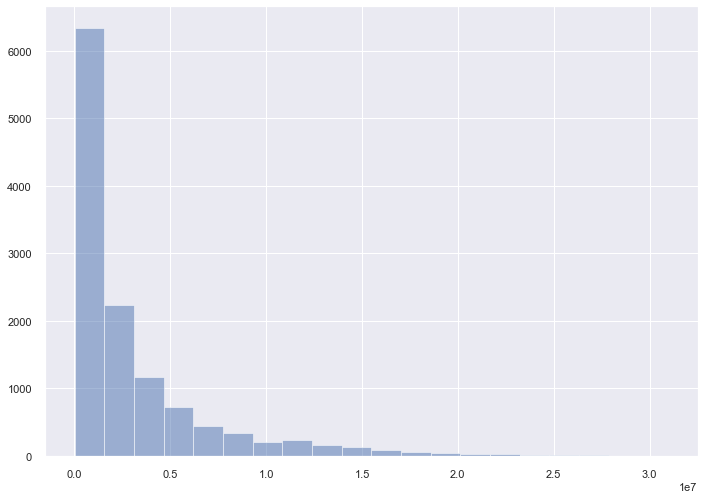

In [344]:
df.salary.hist(bins=20, alpha=0.5)

In [345]:
# labels = ["One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine", "Ten"]
labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
df["categorical_salary"] = pd.qcut(df.salary, q=10, labels=False)

In [346]:
df["categorical_salary"].unique()

array([1, 2, 3, 5, 6, 7, 4, 8, 9, 0])

In [347]:
df["categorical_salary"].describe()

count    12233.000000
mean         4.495790
std          2.874956
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: categorical_salary, dtype: float64

In [348]:
# for label in labels:
#    print(df.loc[df["categorical_salary"] == label].size)

In [349]:
df["categorical_salary"] = df["categorical_salary"].astype(int)

# === === === === === === === === === ===
# Train / Test Split

In [350]:
split_df = df

## Trainingsdaten

In [351]:
X = split_df.drop(columns = ["salary", "categorical_salary"])

### Top Ten Correlation Features

Die zuvor berechneten top 10 Correlation Features zu nehmen würde in einem schlechteren _Linear Regression Score_ resultieren.

In [352]:
# X = X[top_10_correlations]

### Top 30 Linear Regression Score Features

Die später berechneten top 30 Linear Regression Features zu nehmen würde in einem schlechteren _Linear Regression Score_ resultieren.

In [353]:
"""
top_30 = [
    'TRB', 'PTS', 'DRB', 'drafted_player_False', 'drafted_player_True',
    'FG', 'FGA', '2PA', 'attended_college_False',
    'attended_college_True', 'ORB', 'FT', '3PA',
    'attended_high_school_False', 'attended_high_school_True', '3P',
    '2P', 'position_PF', 'shoots_Right', 'shoots_Left', 'position_C',
    'position_PG', 'position_SF', 'position_SG', 'team_LAC',
    'team_CLE', 'team_PHO', 'team_IND', 'team_GSW', 'team_NYK'
]
X = X[top_30]
"""

"\ntop_30 = [\n    'TRB', 'PTS', 'DRB', 'drafted_player_False', 'drafted_player_True',\n    'FG', 'FGA', '2PA', 'attended_college_False',\n    'attended_college_True', 'ORB', 'FT', '3PA',\n    'attended_high_school_False', 'attended_high_school_True', '3P',\n    '2P', 'position_PF', 'shoots_Right', 'shoots_Left', 'position_C',\n    'position_PG', 'position_SF', 'position_SG', 'team_LAC',\n    'team_CLE', 'team_PHO', 'team_IND', 'team_GSW', 'team_NYK'\n]\nX = X[top_30]\n"

### Ausschließlich Saisonstatistiken 

Die ausschließliche Verwendung der Saisonstatistiken würde in einem schlechteren _Linear Regression Score_ resultieren.

In [354]:
statistics = [
    "3P%",
    "FT%",                   
    "2P%",                      
    "FTr",                       
    "FG%",                     
    "eFG%",                  
    "3PAr",                   
    "TS%",                    
    "TOV%",                  
    "ORB%",                      
    "TRB%",                      
    "DRB%",                      
    "WS/48",                     
    "BLK%",                       
    "PER",                        
    "STL%",                     
    "USG%",                      
    "AST%",
    "MP",                         
    "GS",                         
    "G",                                                           
    "PTS",                        
    "PF",                         
    "OWS",                        
    "TOV",                        
    "BLK",                        
    "STL",                        
    "AST",                        
    "TRB",                        
    "DRB",                        
    "ORB",                        
    "FTA",                        
    "FT",                         
    "2PA",                        
    "2P",                         
    "3PA",                        
    "3P",                         
    "FGA",                        
    "FG",                         
    "VORP",                       
    "BPM",                        
    "DBPM",                       
    "OBPM",                       
    "WS",                         
    "DWS"
]

In [355]:
# X = X[statistics]

### Verwerfen von Features

Das Verwerfen der folgenden Features führt zu leichten Verbesserungen des _Linear Regression Score_.

In [356]:
X.drop(columns = ["season_start"], inplace=True)

In [357]:
X.drop(columns = ["3P%"], inplace=True)

## Testdaten

In [358]:
# y = split_df["salary"]

In [359]:
y = split_df["categorical_salary"]

In [360]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [361]:
# X = ((X-X.min())/(X.max()-X.min()))

In [362]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# === === === === === === === === === ===
# Linear Regression

In [363]:
# With StandardScaler
X_train_linear = X_train_std
X_test_linear = X_test_std

# Without StandardScaler
# X_train_linear = X_train
# X_test_linear = X_test

y_train_linear = y_train
y_test_linear = y_test

In [364]:
model = LinearRegression().fit(X_train_linear, y_train_linear)
y_pred = model.predict(X_test_linear)

In [365]:
# print the coefficients
print(model.intercept_)
print(model.coef_)

4.491958584534229
[ 1.35689365e+00  1.07602694e-01  1.60265963e-01  7.57810749e-01
 -4.86867711e-01  8.48389398e-02  1.48896568e+00  9.72559062e-02
  3.42779076e-02 -5.09598487e-01 -7.64412072e-02 -4.95978943e-01
  1.62295507e-01  2.64956026e-01 -7.77082940e-02 -9.66907593e-02
  3.22888880e-02  1.23688397e-01  3.61178132e-01  7.68245818e-01
  1.43487828e-01  1.03655020e+00 -5.92064581e-01 -4.29777141e-01
 -7.23893243e-01  1.94128213e+00 -6.37256753e-01 -7.81168569e+10
  9.45187922e+10 -4.03548742e-01  5.81472514e+09 -2.91489538e+10
  3.75935054e+10 -8.08774692e+10  4.41398621e-02  2.55165100e-02
 -1.08808139e+10  1.58234406e+00 -3.10130119e-02 -2.00698579e+10
 -4.36195470e+10  6.16807217e+10 -7.42263794e-01 -1.85091972e-01
  8.70666504e-02  1.12288284e+00 -1.25679016e-01  4.87416390e+10
 -5.41959086e+10 -5.41959086e+10 -9.77548436e+10 -9.77548436e+10
  8.16126539e+10  7.25264789e+09  8.18801029e+10  5.43836465e+10
  5.56809400e+10  5.37002354e+10  5.33944413e+10  5.33172588e+10
  2.531

In [366]:
pd.DataFrame(abs(df.corr().salary).sort_values(ascending = False))

,salary
salary,1.000000
categorical_salary,0.781640
WS,0.426963
VORP,0.415971
PTS,0.414596
...,...
team_MIN,0.001989
team_NOK,0.001679
team_DET,0.000843
team_CLE,0.000121


In [367]:
zipped = list(zip(X_train.columns, model.coef_))
data = pd.DataFrame(zipped, columns=['feature', 'coef'])
data = data.reindex(data.coef.abs().sort_values(ascending = False).index)

In [368]:
data.head(2)

,feature,coef
51,drafted_player_True,-9.775484e+10
50,drafted_player_False,-9.775484e+10


In [369]:
data.tail(2)

,feature,coef
38,FT%,-0.031013
35,eFG%,0.025517


In [370]:
print('coefficient of determination: {}'.format(model.score(X_test_linear, y_test_linear)))

coefficient of determination: 0.5863445231372588


In [371]:
linear_score = round(explained_variance_score(np.array(y_test_linear), y_pred) * 100, 2)
print('linear regression score: {}%'.format(linear_score))

linear regression score: 58.64%


In [372]:
print(mean_squared_error(np.array(y_test_linear), y_pred))

3.3577305404249818


# === === === === === === === === === ===
# KNN

In [373]:
X_train_knn = X_train_std
X_test_knn = X_test_std

y_train_knn = y_train
y_test_knn = y_test

## Anwendung

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [374]:
first = [50, 75, 100, 125, 150, 175, 200]
second = [100, 112, 125, 127, 150]
third = [100, 106, 112, 119, 125]
fourth = [111, 112, 113]
fifth = [112, 113, 114, 115]
sixth = [113]

In [375]:
def do_grid_search_for_knn():
    param_grid = {
        'n_neighbors': sixth,
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance'],
    }
    
    clf = GridSearchCV(KNeighborsClassifier(), param_grid, verbose = 1, cv = 3, n_jobs = -1)
    return clf.fit(X_train_knn, y_train_knn)
    

In [376]:
# grid_knn = do_grid_search_for_knn()

## Ergebnis

In [377]:
def print_outcome_for_knn():
    print('best params:\n', grid_knn.best_params_, '\n')
    print('best score:\n', grid_knn.best_score_, '\n')
    print('best score (%):\n', round(grid_knn.best_score_ * 100, 2), '\n')

In [378]:
# print_outcome_for_knn()

In [379]:
# pd.DataFrame(grid_knn.cv_results_)

https://towardsdatascience.com/the-basics-knn-for-classification-and-regression-c1e8a6c955

--> Letzter Absatz

# === === === === === === === === === ===
# Decision Tree

In [380]:
X_train_dt = X_train_std
X_test_dt = X_test_std

y_train_dt = y_train
y_test_dt = y_test

## Anwendung

In [381]:
def do_grid_search_for_dt():
    param_grid = {
        # 'max_depth': range(1,30),
        # 'criterion': ["entropy", "gini"]
        'max_depth': [7], # Best Settings
        'criterion': ["entropy"] # Best Settings
    }

    clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, verbose=False, cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True) ,n_jobs = -1)
    return clf.fit(X_train_dt, y_train_dt) 

In [382]:
# grid_dt = do_grid_search_for_dt()

## Ergebnis

In [383]:
def print_outcome_for_dt():
    print('best params:\n', grid_dt.best_params_, '\n')
    print('best score:\n', grid_dt.best_score_, '\n')
    print('best score (%):\n', round(grid_dt.best_score_ * 100, 2), '\n')
    print('best estimator:\n', grid_dt.best_estimator_, '\n')

In [384]:
# print_outcome_for_dt()

### Darstellung

In [385]:
"""
column_names = X_train.columns

dot_data = StringIO()  

export_graphviz(grid_dt.best_estimator_, out_file=dot_data,  
                feature_names=column_names,
                filled=True, rounded=True,
                proportion=True,
                special_characters=True)  

(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())
"""

'\ncolumn_names = X_train.columns\n\ndot_data = StringIO()  \n\nexport_graphviz(grid_dt.best_estimator_, out_file=dot_data,  \n                feature_names=column_names,\n                filled=True, rounded=True,\n                proportion=True,\n                special_characters=True)  \n\n(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())\n\nImage(graph.create_png())\n'

# === === === === === === === === === ===
# Neural Network

In [386]:
X_train_nn = X_train_std
X_test_nn = X_test_std

y_train_nn = y_train
y_test_nn = y_test

## Anwendung

In [387]:
first = [
    (1,),  (8,), (16,), (32,), (64,), (128,), (256,), (512,),
    (1, 1),  (8, 8), (16, 16), (32, 32), (64, 64), (128, 128), (256, 256), (512, 512),
    (1, 1, 1),  (8, 8, 8), (16, 16, 16), (32, 32, 32), (64, 64, 64), (128, 128, 128), (256, 256, 256), (512, 512, 512),
]

In [388]:
def do_grid_search_for_nn():
    param_grid = {
        # 'hidden_layer_sizes': first,
        # 'activation': ['tanh', 'relu', 'logistic', 'identity']
        "hidden_layer_sizes": [(32, 32)], # Best Settings
        'activation': ['logistic']
    }
    
    mlp = MLPClassifier(max_iter=200)
    clf = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy')
    return clf.fit(X_train_nn, y_train_nn)

In [389]:
# grid_nn = do_grid_search_for_nn()

## Ergebnis

In [390]:
def print_outcome_for_nn():
    print('best params:\n', grid_nn.best_params_)
    
    predictions = grid_nn.predict(x_test_nn);
    print('predictions:\n', grid.predict(x_test_nn))
    
    print('confusion matrix:\n', confusion_matrix(y_test_nn, predictions))
    print('classification report:\n', classification_report(y_test_nn, predictions))

In [391]:
# print_outcome_for_nn()

# === === === === === === === === === ===
# PCA

In [392]:
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)

print(X.shape)
print(x_pca.shape)

(12233, 101)
(12233, 2)


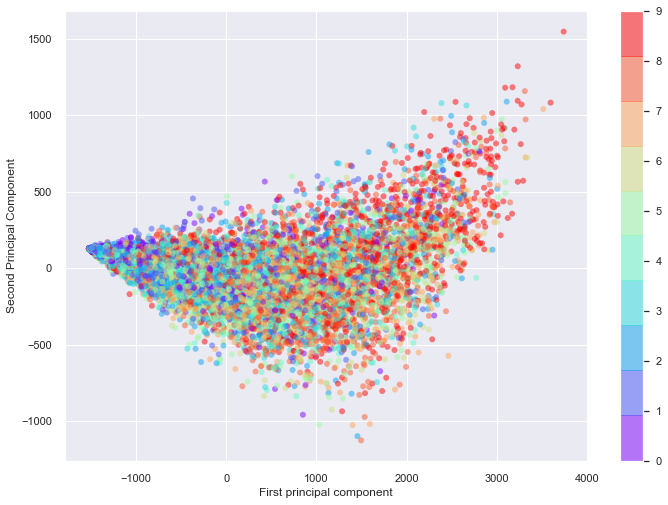

In [393]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y[:], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.colorbar()

In [394]:
x_pca[:, 0]
x_pca[:, 1]

array([120.89693053,  95.46422858,  57.57048999, ...,  95.79273611,
       -99.65588433, 111.29971378])

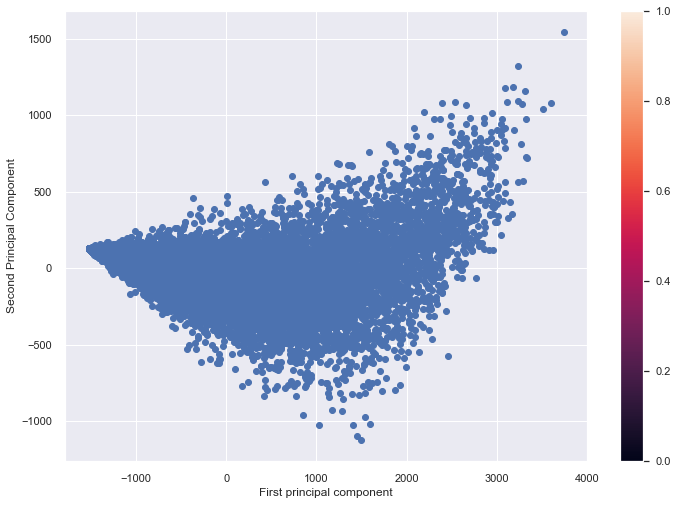

In [395]:
plt.scatter(x_pca[:, 0], x_pca[:, 1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.colorbar()

In [396]:
pca_df = pd.DataFrame(x_pca, columns=["first_pc", "second_pc"])

In [397]:
pca_df['college'] = college_feature

In [398]:
pca_df = pd.melt(pca_df, 'college', var_name="measurement")

In [399]:
pca_df

,college,measurement,value
0,Duke University,first_pc,-1135.131105
1,Duke University,first_pc,-297.684566
2,Duke University,first_pc,-45.803990
3,Duke University,first_pc,-1320.440939
4,Duke University,first_pc,-1488.909145
...,...,...,...
24461,"University of California, Los Angeles",second_pc,134.495882
24462,"University of California, Los Angeles",second_pc,132.252290
24463,"University of Nevada, Las Vegas",second_pc,95.792736
24464,NO_COLLEGE,second_pc,-99.655884


In [400]:
iris_df = sn.load_dataset('iris')

In [401]:
pca_df.college.head(20)

0                                       Duke University
1                                       Duke University
2                                       Duke University
3                                       Duke University
4                                       Duke University
5                            Louisiana State University
6                            Louisiana State University
7                            Louisiana State University
8                            Louisiana State University
9                            Louisiana State University
10                           Louisiana State University
11                           Louisiana State University
12                           Louisiana State University
13                           Louisiana State University
14    University of Michigan, San Jose State University
15    University of Michigan, San Jose State University
16    University of Michigan, San Jose State University
17    University of Michigan, San Jose State Uni

In [402]:
# pca_df.second_pc.size

In [403]:
# sn.set(style="whitegrid", palette="muted")
# sn.swarmplot(x="measurement", y="value", hue="college", data=pca_df)
# plt.legend(loc="lower right")
# plt.show()

In [404]:
# sn.lmplot(x="first_pc", y="second_pc", data=pca_df, fit_reg=False, hue="college", legend=False)
# plt.legend(loc="lower right")
# plt.show()

In [405]:
# https://medium.com/analytics-vidhya/principal-component-analysis-pca-with-code-on-mnist-dataset-da7de0d07c22

# === === === === === === === === === ===
# T-SNE

In [406]:
def do_tsne(n_iter, perplexity = 25):
    time_start = time.time()
    tsne = TSNE(n_iter=n_iter, perplexity=perplexity)
    tsne_results = tsne.fit_transform(X)
    
    print('time in seconds:', time.time() - time_start, '\n')
    print('time in minutes:', (time.time() - time_start) / 60, '\n')
    print("iterations:", tsne.n_iter_, '\n')
    print("perplexity: ", perplexity, '\n')
    print("Kullback-Leibler divergance:", tsne.kl_divergence_, '\n')
    
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', 10))

 ========== 250 ITERATIONS - FIRST ========== 

time in seconds: 11.304282188415527 

time in minutes: 0.18840718666712444 

iterations: 250 

perplexity:  25 

Kullback-Leibler divergance: 1.7976931348623157e+308 



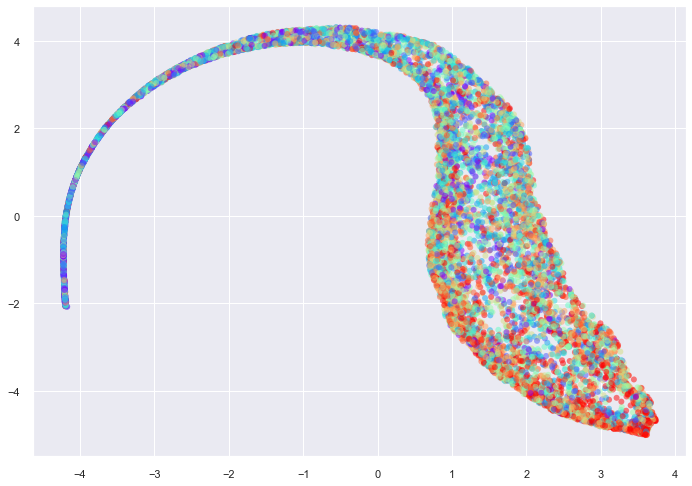

In [407]:
print(" ========== 250 ITERATIONS - FIRST ========== \n")
# do_tsne(250)

 ========== 250 ITERATIONS - SECOND ========== 

time in seconds: 12.159067153930664 

time in minutes: 0.20265448490778606 

iterations: 250 

perplexity:  25 

Kullback-Leibler divergance: 1.7976931348623157e+308 



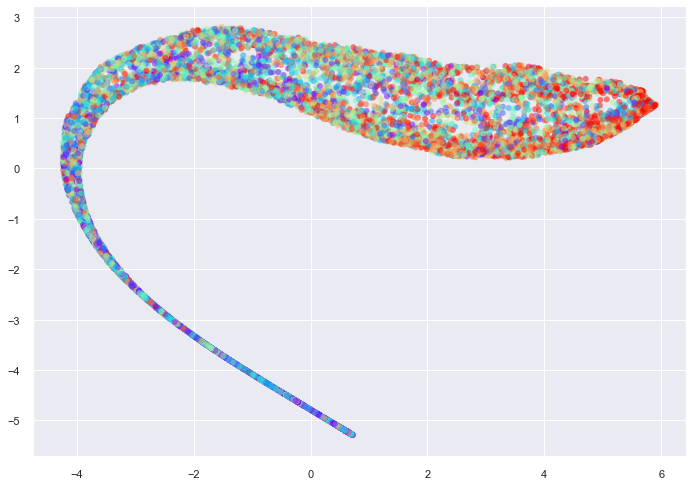

In [408]:
print(" ========== 250 ITERATIONS - SECOND ========== \n")
# do_tsne(250)

 ========== 500 ITERATIONS - FIRST ========== 

time in seconds: 20.439366817474365 

time in minutes: 0.34065964619318645 

iterations: 499 

perplexity:  25 

Kullback-Leibler divergance: 1.962647557258606 



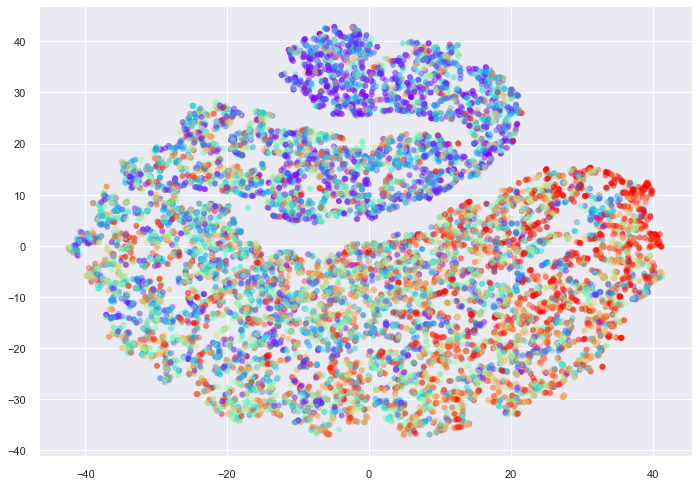

In [409]:
print(" ========== 500 ITERATIONS - FIRST ========== \n")
# do_tsne(500)

 ========== 500 ITERATIONS - SECOND ========== 

time in seconds: 21.50175976753235 

time in minutes: 0.35836541652679443 

iterations: 499 

perplexity:  25 

Kullback-Leibler divergance: 1.9977800846099854 



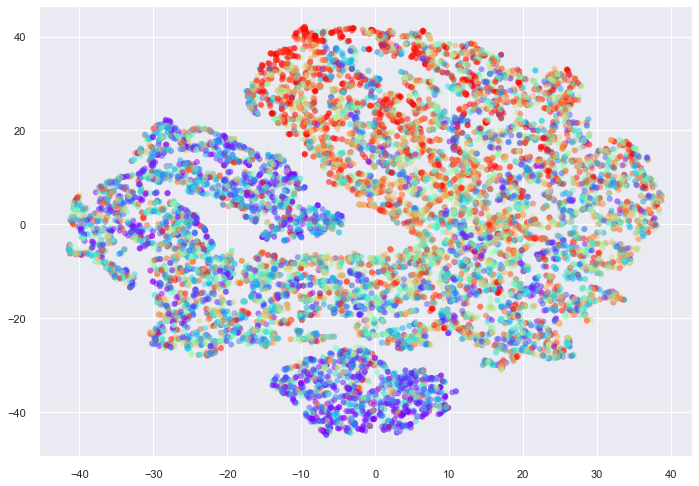

In [410]:
print(" ========== 500 ITERATIONS - SECOND ========== \n")
# do_tsne(500)

 ========== 1000 ITERATIONS - FIRST ========== 

time in seconds: 39.59926390647888 

time in minutes: 0.6599903543790181 

iterations: 999 

perplexity:  25 

Kullback-Leibler divergance: 1.614619493484497 



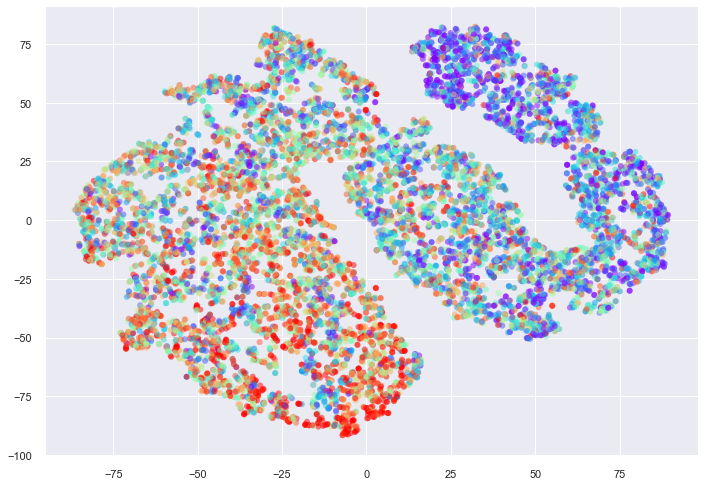

In [411]:
print(" ========== 1000 ITERATIONS - FIRST ========== \n")
# do_tsne(1000)

 ========== 1000 ITERATIONS - SECOND ========== 

time in seconds: 41.07995581626892 

time in minutes: 0.6846726338068644 

iterations: 999 

perplexity:  25 

Kullback-Leibler divergance: 1.5942957401275635 



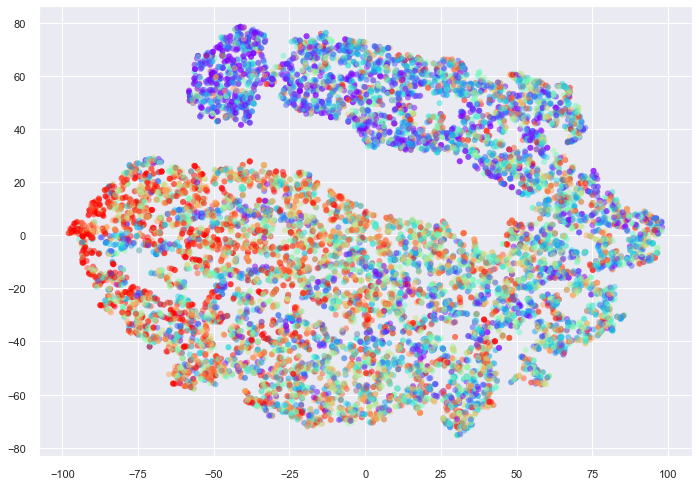

In [412]:
print(" ========== 1000 ITERATIONS - SECOND ========== \n")
# do_tsne(1000)

 ========== 20000 ITERATIONS - FIRST ========== 

time in seconds: 77.04017472267151 

time in minutes: 1.284005598227183 

iterations: 1999 

perplexity:  25 

Kullback-Leibler divergance: 1.5193407535552979 



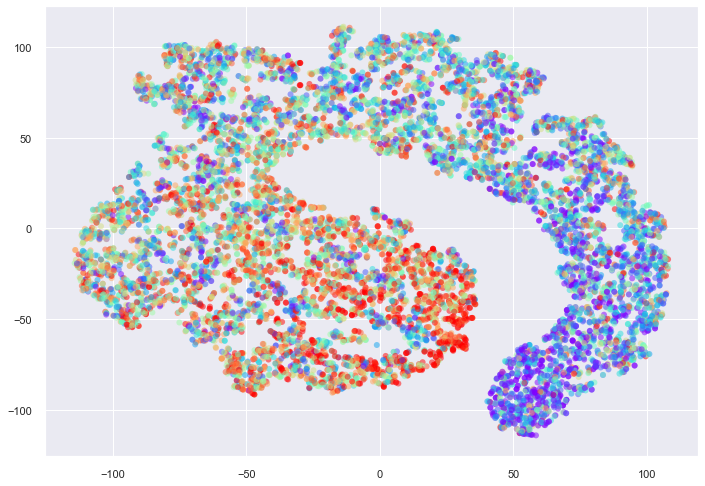

In [414]:
print(" ========== 20000 ITERATIONS - FIRST ========== \n")
# do_tsne(2000)

 ========== 20000 ITERATIONS - SECOND ========== 

time in seconds: 79.60542631149292 

time in minutes: 1.3267609516779582 

iterations: 1999 

perplexity:  25 

Kullback-Leibler divergance: 1.5554983615875244 



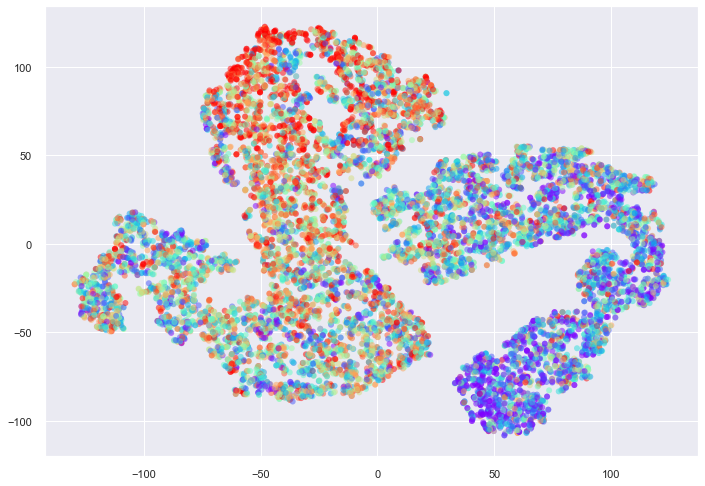

In [415]:
print(" ========== 20000 ITERATIONS - SECOND ========== \n")
# do_tsne(2000)

# === === === === === === === === === ===
# KMeans

In [413]:
wcss = []
for n_clusters in range(1, 20):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    print('K: ', n_clusters)
    print('Inertia: ', kmeans.inertia_)

NameError: name 'KMeans' is not defined

In [ ]:
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()